# TRINE STATE

In [1]:
import torch
from torch import nn
import numpy as np
from qibo import Circuit, gates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import datetime

In [2]:
def build_ancilla_vqc(x_input, thetas):
    """
    2-qubit VQC with 2 rotation layers + 2 entangling layers for 3-class trine state classification.
    
    x_input: 0,1,2 for trine states
    thetas: list or array of 4 parameters
    """
    assert len(thetas) == 12, "Require more (less) parameters for this ansatz"
    
    circuit = Circuit(2)
    
    # --- Prepare trine input state on system qubit (0) ---
    #circuit.add(gates.H(0))
    circuit.add(gates.RY(0, 2 * np.pi * x_input / 3))

    for i in range(6):

        circuit.add(gates.CNOT(0, 1))

        circuit.add(gates.RY(0, thetas[2*i + 0]))

        circuit.add(gates.RY(1, thetas[2*i + 1]))    

    
    # --- Measurement ---
    circuit.add(gates.M(0, 1))
    
    return circuit


In [3]:
def parameter_shift_rule(x_input, thetas, label, n_shots, shift=np.pi/2):
    n_params = len(thetas)
    grad = np.zeros(n_params)

    for i in range(n_params):
        # Create shifted parameter vectors
        theta_plus = thetas.copy()
        theta_minus = thetas.copy()
        theta_plus[i] += shift
        theta_minus[i] -= shift

        # Evaluate circuit at shifted parameters
        result_plus = build_ancilla_vqc(x_input, theta_plus)(nshots=n_shots)
        counts_plus = result_plus.frequencies()
        # print("counts_plus", counts_plus)
        
        result_minus = build_ancilla_vqc(x_input, theta_minus)(nshots=n_shots)
        counts_minus = result_minus.frequencies()    
        

        # Map measurement outcomes to class probabilities
        mapping = {"00":0, "01":1, "10":2}
        p_plus = np.zeros(3)
        p_minus = np.zeros(3)
        for bitstring, freq in counts_plus.items():
            if bitstring in mapping:
                p_plus[mapping[bitstring]] += freq / n_shots
        for bitstring, freq in counts_minus.items():
            if bitstring in mapping:
                p_minus[mapping[bitstring]] += freq / n_shots

        # Clip to avoid log(0)
        eps = 1e-8
        p_plus = np.clip(p_plus, eps, 1 - eps)
        p_minus = np.clip(p_minus, eps, 1 - eps)

        # Cross-entropy loss
        loss_plus = -np.log(p_plus[label])
        # loss_plus = permutation_invariant_loss_single(p_plus, label)

        loss_minus = -np.log(p_minus[label])
        # loss_minus = permutation_invariant_loss_single(p_minus, label)

        # Parameter-shift gradient
        grad[i] = 0.5 * (loss_plus - loss_minus)

    return grad

In [4]:
class QuantumModel(torch.nn.Module):
    def __init__(self, n_parameters=12):
        super().__init__()
        self.thetas = nn.ParameterList([
                    nn.Parameter(torch.tensor(np.round(np.random.uniform(0, 2*np.pi), 5))) for _ in range(n_parameters)
                    ])

    def forward(self, x_input, n_shots):

        params = []
        
        for param in self.thetas:
            params.append(param.item())
            
        circuit = build_ancilla_vqc(x_input, params)
        result = circuit(nshots=n_shots)
        
        return result

In [5]:
class Client:
    def __init__(self, num_samples, seed, n_shots, vqc_class=QuantumModel, sigma=0):
        
        self.num_samples = num_samples
        self.seed = seed       
        self.model = vqc_class()
        self.sigma = sigma
        self.sample_pointer = 0  
        self.n_shots = n_shots  # Number of shots for gradient calculation

    def _generate_labels(self, balanced=False):
        """
        Generate labels for this client.
        
        balanced: if True, tries to generate approx equal number of samples per class (1/3 each)
        Otherwise, generates probabilities via Gaussian bias + softmax (non-IID).
        """
        np.random.seed(self.seed)
        
        if balanced:
            # Compute number of samples per class
            base_count = self.num_samples // 3
            remainder = self.num_samples % 3  # distribute remaining samples
            counts = [base_count] * 3
            for i in range(remainder):
                counts[i] += 1  # distribute extra samples to first classes
            
            labels = np.array([0]*counts[0] + [1]*counts[1] + [2]*counts[2])
            np.random.shuffle(labels)
        else:
            # Use Gaussian bias + softmax to generate probabilities for 3 classes
            raw_bias = np.random.normal(0, self.sigma, size=3)  # 3 numbers, one per class
            exp_bias = np.exp(raw_bias - np.max(raw_bias))        # for numerical stability
            probs = exp_bias / exp_bias.sum()                    # softmax to get probabilities
    
            labels = np.random.choice([0, 1, 2], size=self.num_samples, p=probs)
            
        self.labels = labels
        return labels

    def get_label_distribution(self):
        """
        Returns the proportion of each class: 0, 1, 2.
        """
        prop_class_0 = np.mean(self.labels == 0)
        prop_class_1 = np.mean(self.labels == 1)
        prop_class_2 = np.mean(self.labels == 2)
        
        return {
            'class_0': prop_class_0,
            'class_1': prop_class_1,
            'class_2': prop_class_2
        }

    def set_thetas(self, new_thetas):
        """
        Set the VQC parameters from a numpy array or list.
        new_thetas: array-like of length n_parameters
        """
        with torch.no_grad():
            for i, param in enumerate(self.model.thetas):
                param.copy_(torch.tensor(new_thetas[i], dtype=param.dtype))
    
    
    def get_thetas(self):
        """
        Return the current VQC parameters as a numpy array.
        """
        return np.array([param.detach().cpu().numpy() for param in self.model.thetas])


    def local_train(self, batch_size, lr=0.1):
        """
        Local training for a batch of data using parameter-shift gradients.
        Works with multi-parameter, multi-class VQC.
        """
        # Select next batch
        start = self.sample_pointer
        end = min(start + batch_size, self.num_samples)
        self.sample_pointer = end
    
        if end - start == 0:
            return self.get_thetas()  # No more data
    
        training_data = self.labels[start:end]
        theta_history = []
    
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
    
        local_weights_evolution_aux = []

        # start = datetime.datetime.now()
        for epoch, label in enumerate(training_data):
            x_input = label  # For trine states, label ∈ {0,1,2}
    
            optimizer.zero_grad()
    
            # Estimate gradient via multi-parameter parameter-shift
            
            # print(f"Grad estimation at {start}")
            grad_estimate = parameter_shift_rule(
                x_input, 
                self.get_thetas(), 
                label,
                n_shots=self.n_shots
            )
            # grad_estimate = parameter_shift_rule_parallel(
            #         x_input, self.get_thetas(), label, self.n_shots, max_workers=8
            #     )
            # print(f"Grad estimation took {(datetime.datetime.now() - start).total_seconds()} seconds")
            # print(grad_estimate)
    
            # Manually assign gradients to all parameters
            for i, param in enumerate(self.model.thetas):
                param.grad = torch.tensor(grad_estimate[i], dtype=param.dtype)
    
            optimizer.step()
            # print(f"1 sample processing took {(datetime.datetime.now() - start).total_seconds()} seconds")
        # print(f"1 local client train took {(datetime.datetime.now() - start).total_seconds()} seconds")


In [6]:
def create_clients_setup(num_clients, num_samples, n_shots, sigma_range=(0.0, 0.0), seed=0, vqc_class=QuantumModel):
    np.random.seed(seed)
    clients = []

    for i in range(num_clients):
        sigma = np.random.uniform(*sigma_range)
        client_seed = seed + i
        client = Client(sigma=sigma, 
                        num_samples=num_samples, 
                        seed=client_seed, 
                        vqc_class=vqc_class,
                        n_shots=n_shots)
        clients.append(client)

    return clients

In [7]:
def compute_Psuccess(client, num_samples_test=1000000):
    Ps0 = client.model(0, n_shots=num_samples_test).frequencies()['00']/num_samples_test
    Ps1 = client.model(1, n_shots=num_samples_test).frequencies()['01']/num_samples_test
    Ps2 = client.model(2, n_shots=num_samples_test).frequencies()['10']/num_samples_test
    

    Psuc = 1/3 * (Ps0 + Ps1 + Ps2)
    return Psuc

In [8]:
def repeat_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - lr: {lr_values}")

    all_mean_Psucs = []
    all_min_Psucs = []

    client_last_thetas = []
    # step_count = int(len(seeds) / 10)

    for seed in seeds:
        # if seed%step_count==0:
        print(f"Seed #{seed}")
        mean_Psucs = []
        min_Psucs = []
        
        for lr in lr_values:
            Psucs = []
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

            for client in clients:
                client._generate_labels()
                client.local_train(client.num_samples, lr=lr)
                client_last_thetas.append(client.get_thetas())
                client_psuc = np.round(compute_Psuccess(client), 4)
                Psucs.append(client_psuc)
            
            mean_Psucs.append(np.mean(Psucs))
            min_Psucs.append(np.min(Psucs))
        
        all_mean_Psucs.append(mean_Psucs)
        all_min_Psucs.append(min_Psucs)

    return np.array(all_mean_Psucs), np.array(all_min_Psucs), client_last_thetas

In [9]:
def compute_optimal_lr(all_Psucs, lr_values, num_seeds):
      
    data_per_lr = all_Psucs.T  # (40, 3)
    data_list = [data_per_lr[i, :] for i in range(data_per_lr.shape[0])]
    
    plt.figure(figsize=(12, 6))
    
    # use integer positions instead of actual LR values for spacing
    positions = np.arange(len(lr_values))
    
    plt.boxplot(data_list, positions=positions, widths=0.6, patch_artist=True)
    
    # make x-ticks readable
    plt.xticks(
        positions[::2],  # show every 2nd tick
        [f"{lr:.2f}" for lr in lr_values[::2]], 
        rotation=45,
    )
    
    plt.xlabel("Learning rate")
    plt.ylabel("Mean Psuc")
    plt.title(f"Performance across {num_seeds} seeds for different learning rates")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # optional: overlay mean line
    means = data_per_lr.mean(axis=1)
    plt.plot(positions, means, color="red", marker="o", linewidth=2, label="Mean across seeds")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


    # compute mean across seeds for each lr
    means = data_per_lr.mean(axis=1)
    
    # find best lr
    best_idx = np.argmax(means)
    best_lr = lr_values[best_idx]
    best_value = means[best_idx]
    
    print(f"Best learning rate: {best_lr:.2f} with mean Psuc = {best_value:.4f}")
 

    return np.round(best_lr, 2)

In [10]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x, axis=0)
    mean_y = np.mean(y, axis=0)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [11]:
def run_federated_training_ECAI(clients, num_rounds, lr, local_batch_size):
    # avg_params = []
    for rnd in range(num_rounds):
        avg_params = []
        #print(f"\n--- Round {rnd+1} ---")

        local_weights = []

        for client in clients:
            client.local_train(batch_size=local_batch_size, lr=lr)
            avg_params.append(client.get_thetas())

        # Federated averaging
        global_thetas = average_angles_modulo(avg_params)

        # print(f"Local weights: {local_weights}, Average: {global_weights}")

        # Broadcast new weights
        for client in clients:
            client.set_thetas(global_thetas)
        # print(client.get_thetas())

In [12]:
def repeat_ECAI_QFL_setup(lr_values, seeds, num_clients, num_samples, sigma_range, n_shots, 
                          num_rounds, local_batch_size, target_class0_ratio=None):

    print(f" ---- SETUP Info ---- ")
    print(f" - Num Clients: {num_clients}")
    print(f" - Num Samples: {num_samples}")
    print(f" - Sigma: {sigma_range}")
    print(f" - Shots: {n_shots}")
    print(f" - Number of Rounds: {num_rounds}")
    print(f" - Local Batch: {local_batch_size}")
    print(f" - lr: {lr_values}")
    
    QFL_Psucs = []

    step_count = int(len(seeds) / 10)

    for seed in seeds:
        if seed%step_count==0:
            print(f"Seed #{seed}")
        QFL_Psucs_aux = []
        
        for lr in lr_values:
            clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=seed,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

            for client in clients:
                client._generate_labels()

            run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=lr, 
                                                                   local_batch_size=local_batch_size)
            QFL_client = Client(None, None, None)
            QFL_client.set_thetas(clients[0].get_thetas())
            
            global_psuc = np.round(compute_Psuccess(QFL_client), 4)
            # for client in clients:
            #     client.local_train(client.num_samples, lr=lr)
            #     client_psuc = np.round(compute_Psuccess(client), 4)
            #     Psucs.append(client_psuc)
            
            QFL_Psucs_aux.append(global_psuc)
        
        QFL_Psucs.append(QFL_Psucs_aux)

    return np.array(QFL_Psucs) 

In [13]:
n_shots = 1

## Setup 1 (x5): 10 clients, 50x5 = 250 samples

In [14]:
num_clients = 10
num_samples = 250

### $\sigma=4.0$

In [15]:
sigma_range = (4.0, 4.0)

#### QFL

In [16]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 50

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [17]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 1, 29, 19, 44, 23, 787489)

In [18]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 250
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 50
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0


[Qibo 0.2.23|INFO|2026-01-29 19:44:24]: Using numpy backend on /CPU:0


Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


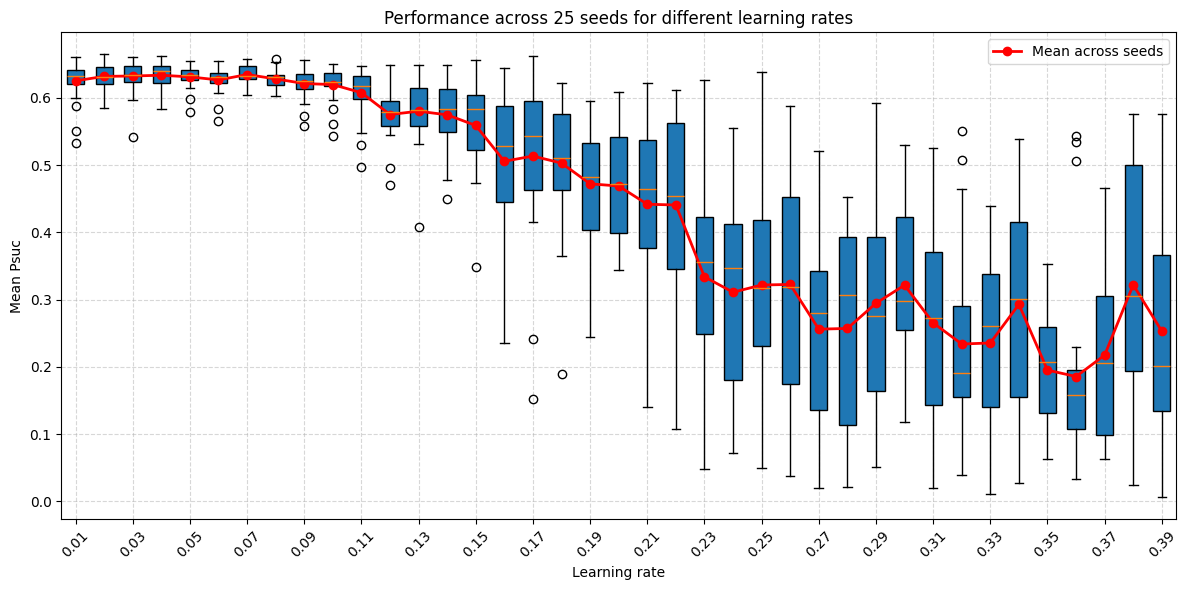

Best learning rate: 0.07 with mean Psuc = 0.6346


In [19]:
opt_lr_qfl_s4_setup1 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [20]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 50

lr_values = [opt_lr_qfl_s4_setup1]
seeds = np.arange(1000, 1100)

In [21]:
QFL_Psucs_s4_setup1 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 250
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 50
 - lr: [np.float64(0.07)]
Seed #1000
Seed #1010
Seed #1020
Seed #1030
Seed #1040
Seed #1050
Seed #1060
Seed #1070
Seed #1080
Seed #1090


In [22]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=123,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()

run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=opt_lr_qfl_s4_setup1, 
                                   local_batch_size=local_batch_size)

client = clients[0]
client.get_thetas()

array([4.20344318, 1.34884057, 2.25361036, 2.43998488, 2.84820465,
       3.86075418, 4.74289917, 1.07314356, 3.08704237, 2.5264405 ,
       3.61505201, 3.32126923])


Test accuracy: 0.589
Confusion matrix (counts):
 [[1979  728  570]
 [ 258 3108   22]
 [1761  775  799]]


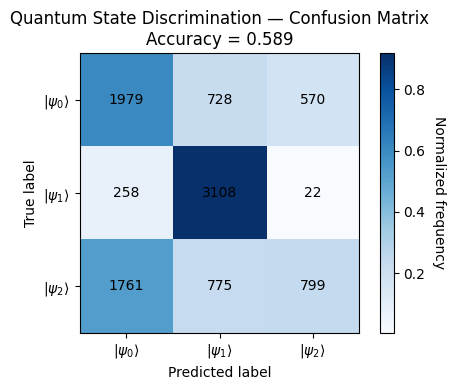

In [23]:
num_test_samples = 10000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [24]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 1, 30, 10, 12, 38, 785540)

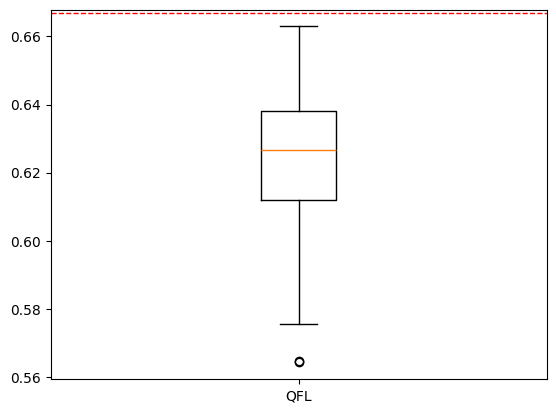

In [25]:
plt.boxplot([QFL_Psucs_s4_setup1.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [26]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [27]:
all_mean_Psucs, all_min_Psucs, _ = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 250
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24


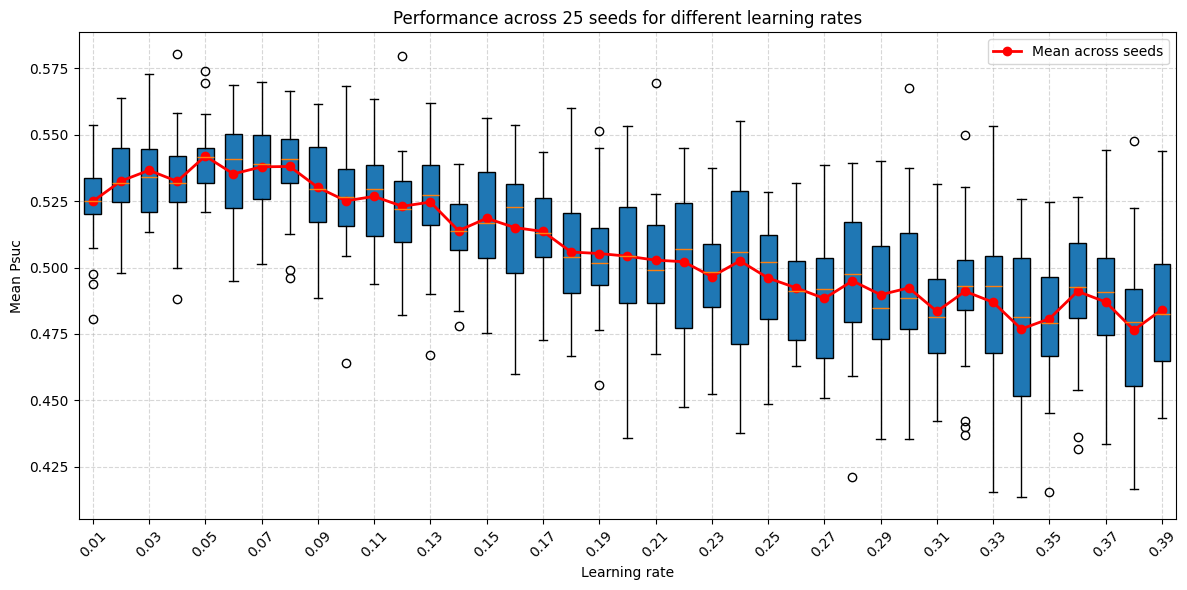

Best learning rate: 0.05 with mean Psuc = 0.5420


In [28]:
opt_lr_1s_s4_setup1 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [29]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s4_setup1]
seeds = np.arange(0, 100)

In [30]:
all_mean_Psucs_1s_s4_setup1, all_min_Psucs_1s_s4_setup1, last_thetas = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 250
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [np.float64(0.05)]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24
Seed #25
Seed #26
Seed #27
Seed #28
Seed #29
Seed #30
Seed #31
Seed #32
Seed #33
Seed #34
Seed #35
Seed #36
Seed #37
Seed #38
Seed #39
Seed #40
Seed #41
Seed #42
Seed #43
Seed #44
Seed #45
Seed #46
Seed #47
Seed #48
Seed #49
Seed #50
Seed #51
Seed #52
Seed #53
Seed #54
Seed #55
Seed #56
Seed #57
Seed #58
Seed #59
Seed #60
Seed #61
Seed #62
Seed #63
Seed #64
Seed #65
Seed #66
Seed #67
Seed #68
Seed #69
Seed #70
Seed #71
Seed #72
Seed #73
Seed #74
Seed #75
Seed #76
Seed #77
Seed #78
Seed #79
Seed #80
Seed #81
Seed #82
Seed #83
Seed #84
Seed #85
Seed #86
Seed #87
Seed #88
Seed #89
Seed #90
Seed #91
Seed #92
Seed #93
Seed #94
Seed #95
Seed #96
Seed #97
Seed #9

/home/rocco/QFL/nb/State-Discrimination/.qsd-venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 17.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


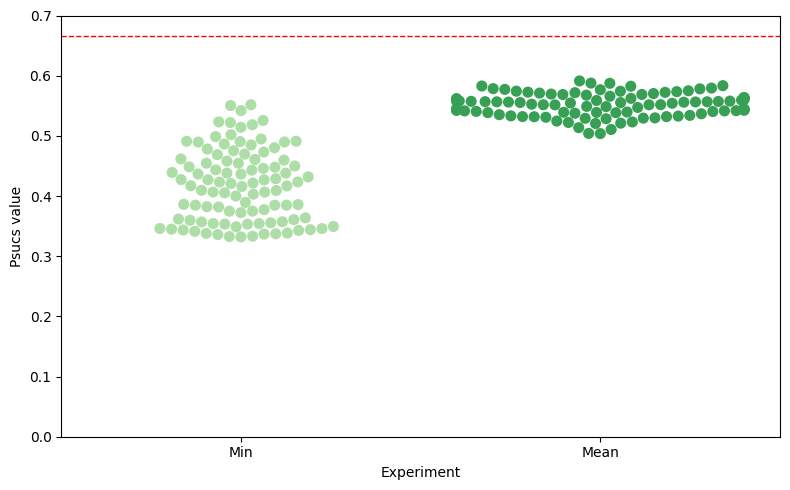

In [31]:
df = pd.DataFrame({
    "Psucs": np.concatenate([all_min_Psucs_1s_s4_setup1.flatten(), all_mean_Psucs_1s_s4_setup1.flatten()]),
    "Experiment": ["Min"] * len(all_min_Psucs_1s_s4_setup1.flatten()) + ["Mean"] * len(all_mean_Psucs_1s_s4_setup1.flatten())
})

plt.figure(figsize=(8, 5))
sns.swarmplot(
    x="Experiment", 
    y="Psucs", 
    hue="Experiment", 
    data=df, 
    palette="Greens", 
    size=8, 
    legend=False  # suppress the redundant legend
)

plt.axhline(y=2/3, color='r', linestyle='--', linewidth=1)
plt.ylim(0.0, 0.7)
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.tight_layout()
plt.show()


In [32]:
np.mean(all_mean_Psucs_1s_s4_setup1)

np.float64(0.5517108)

In [33]:
last_thetas[0]

array([5.72700351, 3.48800306, 4.05685973, 1.44157861, 4.14717204,
       3.71064489, 5.24884487, 4.8387135 , 2.72602483, 6.22028552,
       4.21307252, 4.02613916])

In [34]:
test_client = Client(None, None, None)
test_client.set_thetas(last_thetas[0])
# test_client.set_thetas(np.mean(last_thetas, axis=0))
compute_Psuccess(test_client)

0.5717366666666666

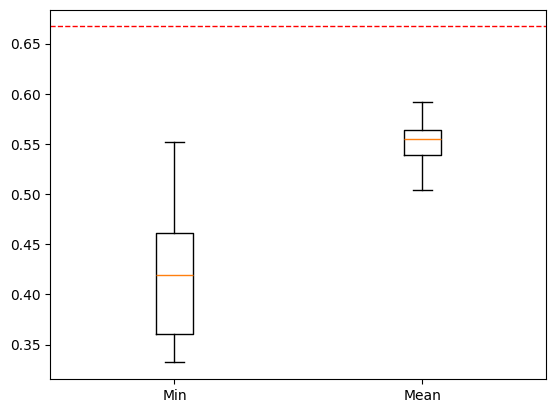

In [35]:
plt.boxplot([all_min_Psucs_1s_s4_setup1.flatten(), all_mean_Psucs_1s_s4_setup1.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

In [36]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=42,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()
    client.local_train(batch_size=len(client.labels), lr=opt_lr_1s_s4_setup1)

client = clients[0]
client.get_thetas()

array([5.69381981, 4.91861842, 3.31902777, 2.10297761, 0.3775528 ,
       0.61696796, 6.07823252, 3.36008622, 4.43258261, 1.157574  ,
       6.6736561 , 5.50996018])


Test accuracy: 0.629
Confusion matrix (counts):
 [[285   0  57]
 [201   0 108]
 [  3   2 344]]


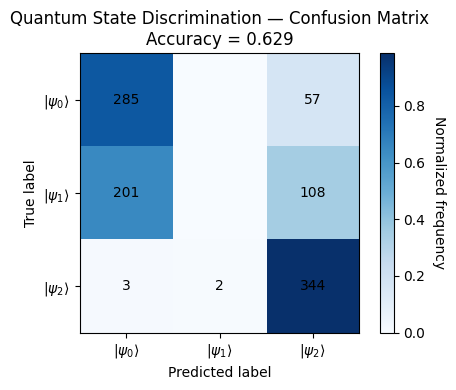

In [37]:
num_test_samples = 1000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


#### Comparisons

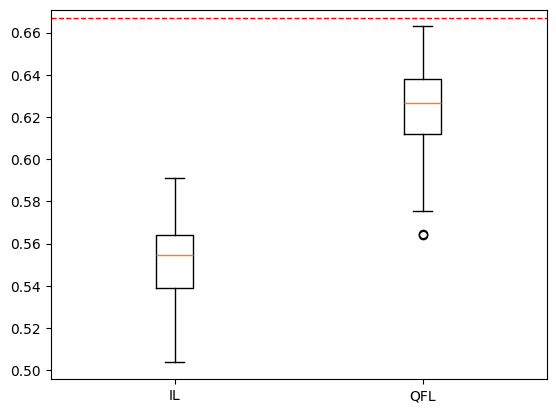

In [38]:
plt.boxplot([all_mean_Psucs_1s_s4_setup1.flatten(), QFL_Psucs_s4_setup1.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

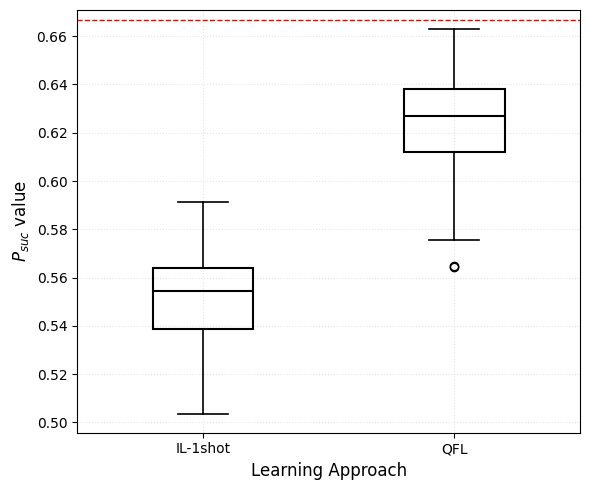

In [208]:
# Data
data = [all_mean_Psucs_1s_s4_setup1.flatten(), QFL_Psucs_s4_setup1.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.6667, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
#plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("trine_setup1_sigma1.png", dpi=600, bbox_inches="tight")
plt.show()

In [40]:
print(np.mean(all_mean_Psucs_1s_s4_setup1))
print(np.mean(QFL_Psucs_s4_setup1))

0.5517108
0.6232140000000002


In [41]:
print(np.min(all_mean_Psucs_1s_s4_setup1), np.max(all_mean_Psucs_1s_s4_setup1))
print(np.min(QFL_Psucs_s4_setup1), np.max(QFL_Psucs_s4_setup1))

0.5037100000000001 0.59128
0.5643 0.6629


## Setup 2 (x5): 10 clients, 25x5 = 125 samples

In [42]:
num_clients = 10
num_samples = 125

### $\sigma=4.0$

In [43]:
sigma_range = (4.0, 4.0)

#### QFL

In [44]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 25

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [45]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 1, 31, 0, 58, 16, 965043)

In [46]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 125
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 25
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


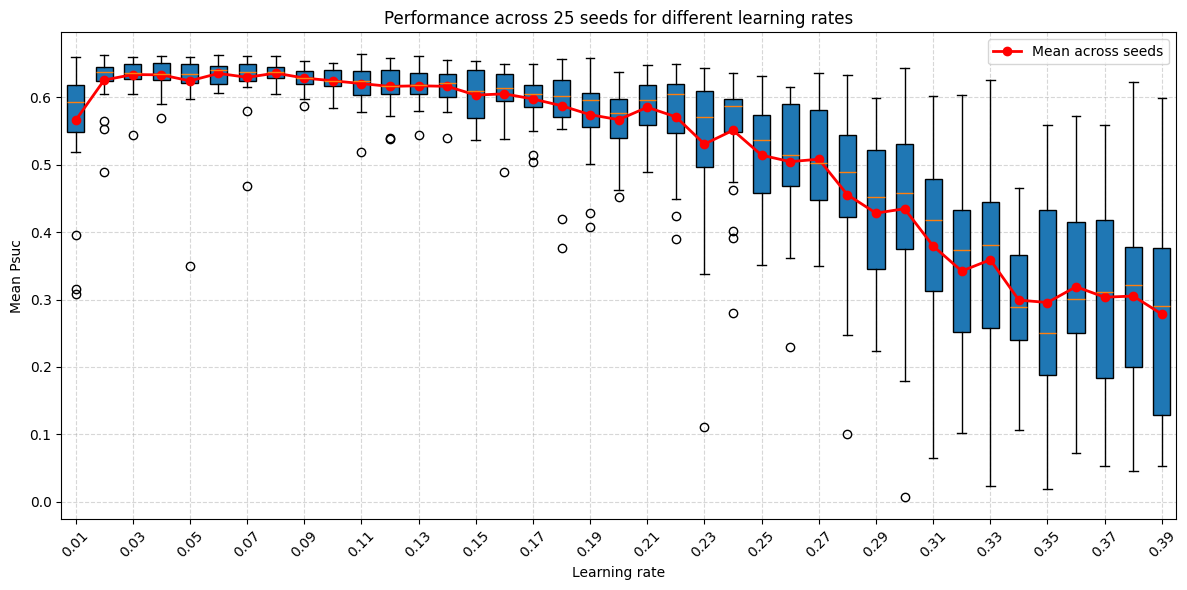

Best learning rate: 0.08 with mean Psuc = 0.6362


In [47]:
opt_lr_qfl_s4_setup2 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [48]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 25

lr_values = [opt_lr_qfl_s4_setup2]
seeds = np.arange(1000, 1100)

In [49]:
QFL_Psucs_s4_setup2 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 125
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 25
 - lr: [np.float64(0.08)]
Seed #1000
Seed #1010
Seed #1020
Seed #1030
Seed #1040
Seed #1050
Seed #1060
Seed #1070
Seed #1080
Seed #1090


In [50]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=123,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()

run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=opt_lr_qfl_s4_setup2, 
                                   local_batch_size=local_batch_size)

client = clients[0]
client.get_thetas()

array([3.45516763, 2.2135854 , 2.21008711, 3.12388939, 2.76806994,
       2.01583828, 4.00417414, 2.1436372 , 3.41674173, 3.70694756,
       5.21339256, 0.25429094])


Test accuracy: 0.611
Confusion matrix (counts):
 [[1597  866  858]
 [  24 3187   52]
 [1314  774 1328]]


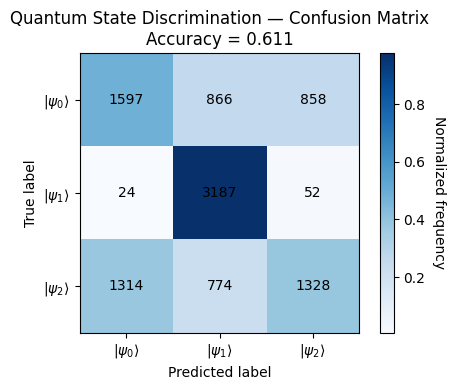

In [51]:
num_test_samples = 10000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [52]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 1, 31, 8, 16, 53, 770694)

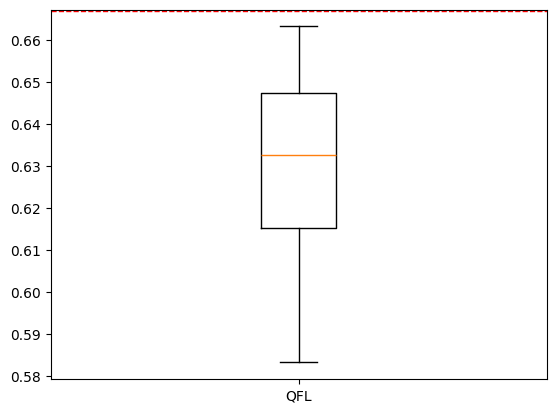

In [53]:
plt.boxplot([QFL_Psucs_s4_setup2.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [54]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [55]:
all_mean_Psucs, all_min_Psucs, _ = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 125
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24


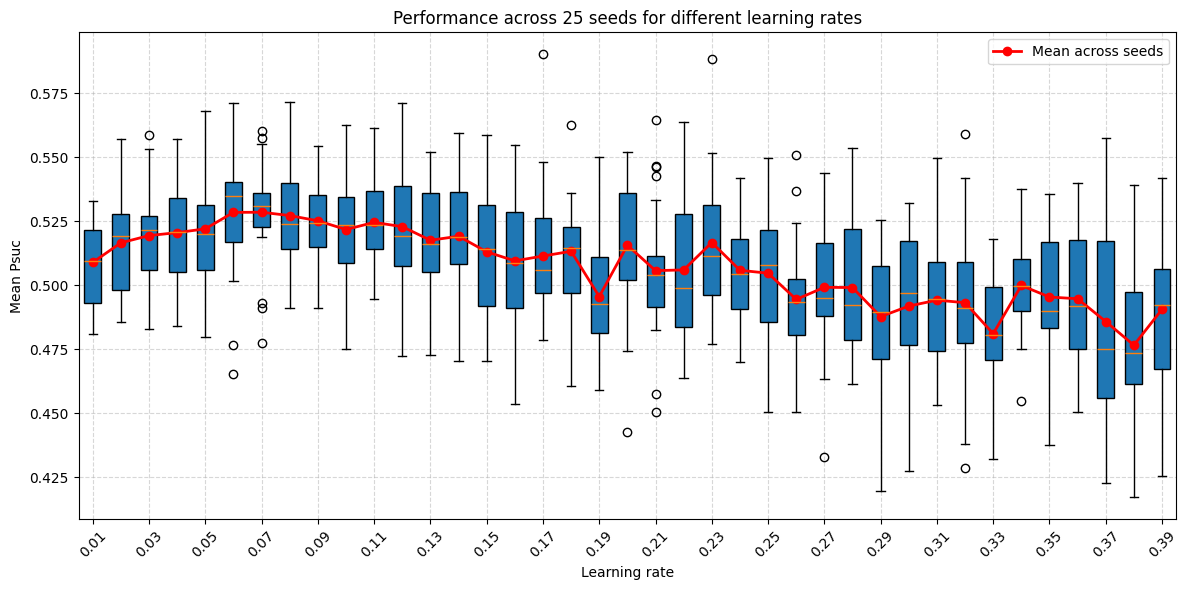

Best learning rate: 0.07 with mean Psuc = 0.5285


In [56]:
opt_lr_1s_s4_setup2 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [57]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s4_setup2]
seeds = np.arange(0, 100)

In [58]:
all_mean_Psucs_1s_s4_setup2, all_min_Psucs_1s_s4_setup2, last_thetas = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 125
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [np.float64(0.07)]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24
Seed #25
Seed #26
Seed #27
Seed #28
Seed #29
Seed #30
Seed #31
Seed #32
Seed #33
Seed #34
Seed #35
Seed #36
Seed #37
Seed #38
Seed #39
Seed #40
Seed #41
Seed #42
Seed #43
Seed #44
Seed #45
Seed #46
Seed #47
Seed #48
Seed #49
Seed #50
Seed #51
Seed #52
Seed #53
Seed #54
Seed #55
Seed #56
Seed #57
Seed #58
Seed #59
Seed #60
Seed #61
Seed #62
Seed #63
Seed #64
Seed #65
Seed #66
Seed #67
Seed #68
Seed #69
Seed #70
Seed #71
Seed #72
Seed #73
Seed #74
Seed #75
Seed #76
Seed #77
Seed #78
Seed #79
Seed #80
Seed #81
Seed #82
Seed #83
Seed #84
Seed #85
Seed #86
Seed #87
Seed #88
Seed #89
Seed #90
Seed #91
Seed #92
Seed #93
Seed #94
Seed #95
Seed #96
Seed #97
Seed #9

/home/rocco/QFL/nb/State-Discrimination/.qsd-venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


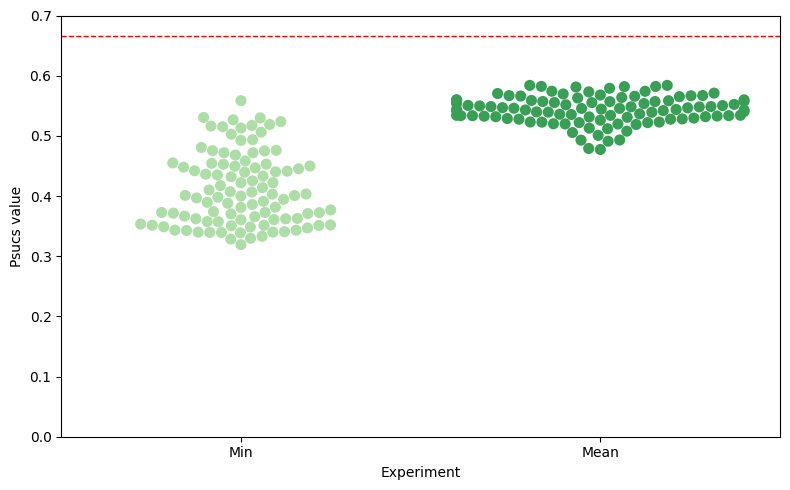

In [59]:
df = pd.DataFrame({
    "Psucs": np.concatenate([all_min_Psucs_1s_s4_setup2.flatten(), all_mean_Psucs_1s_s4_setup2.flatten()]),
    "Experiment": ["Min"] * len(all_min_Psucs_1s_s4_setup2.flatten()) + ["Mean"] * len(all_mean_Psucs_1s_s4_setup2.flatten())
})

plt.figure(figsize=(8, 5))
sns.swarmplot(
    x="Experiment", 
    y="Psucs", 
    hue="Experiment", 
    data=df, 
    palette="Greens", 
    size=8, 
    legend=False  # suppress the redundant legend
)

plt.axhline(y=2/3, color='r', linestyle='--', linewidth=1)
plt.ylim(0.0, 0.7)
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.tight_layout()
plt.show()


In [60]:
np.mean(all_mean_Psucs_1s_s4_setup2)

np.float64(0.543141)

In [61]:
last_thetas[0]

array([4.95908825, 3.00658272, 3.81853102, 2.64956559, 3.40011049,
       4.12899257, 5.84291498, 6.02239203, 2.02188049, 5.15138446,
       4.27103754, 3.71750785])

In [62]:
test_client = Client(None, None, None)
test_client.set_thetas(last_thetas[0])
# test_client.set_thetas(np.mean(last_thetas, axis=0))
compute_Psuccess(test_client)

0.5199659999999999

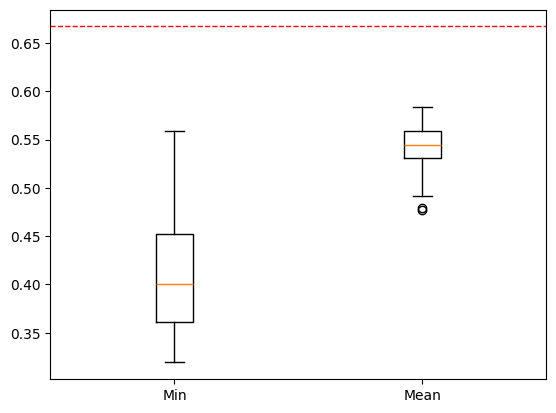

In [63]:
plt.boxplot([all_min_Psucs_1s_s4_setup2.flatten(), all_mean_Psucs_1s_s4_setup2.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

In [64]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=42,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()
    client.local_train(batch_size=len(client.labels), lr=opt_lr_1s_s4_setup2)

client = clients[0]
client.get_thetas()

array([ 5.82688464,  4.49088007,  4.31840781,  1.89272414, -0.20622406,
        0.82376756,  4.64741496,  3.14041448,  3.9906776 ,  1.21473379,
        7.02045498,  5.33267182])


Test accuracy: 0.617
Confusion matrix (counts):
 [[269   0  58]
 [217   0 102]
 [  5   1 348]]


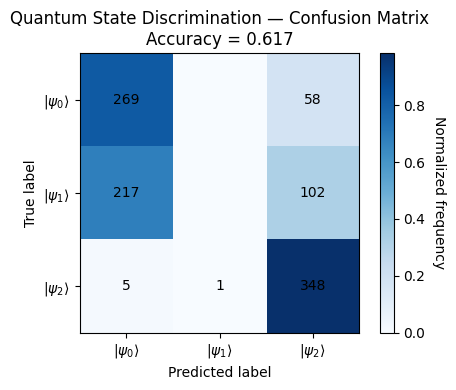

In [65]:
num_test_samples = 1000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


#### Comparisons

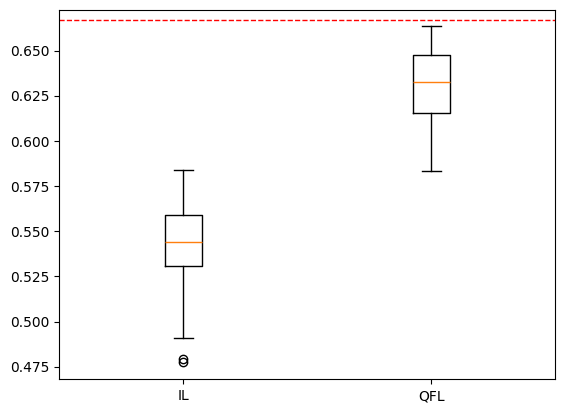

In [66]:
plt.boxplot([all_mean_Psucs_1s_s4_setup2.flatten(), QFL_Psucs_s4_setup2.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

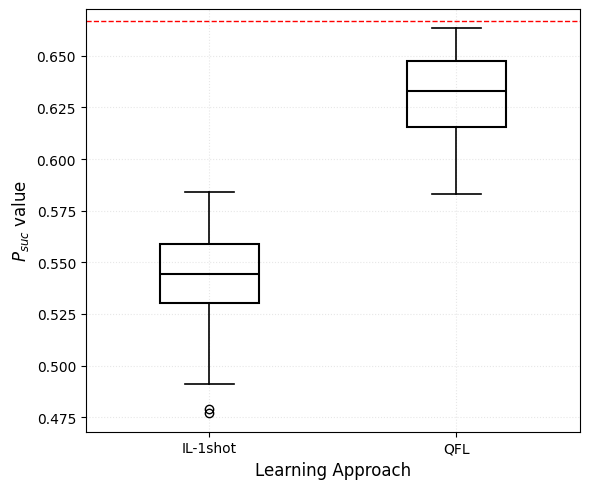

In [209]:
# Data
data = [all_mean_Psucs_1s_s4_setup2.flatten(), QFL_Psucs_s4_setup2.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.6667, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
#plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("trine_setup1_sigma1.png", dpi=600, bbox_inches="tight")
plt.show()

In [68]:
print(np.mean(all_mean_Psucs_1s_s4_setup2))
print(np.mean(QFL_Psucs_s4_setup2))

0.543141
0.630263


In [69]:
print(np.min(all_mean_Psucs_1s_s4_setup2), np.max(all_mean_Psucs_1s_s4_setup2))
print(np.min(QFL_Psucs_s4_setup2), np.max(QFL_Psucs_s4_setup2))

0.47732 0.58387
0.5833 0.6633


## Setup 1 ORIGINAL: 10 clients, 50 samples

In [70]:
num_clients = 10
num_samples = 50

### $\sigma=4.0$

In [71]:
sigma_range = (4.0, 4.0)

#### QFL

In [72]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [73]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 1, 31, 15, 48, 9, 353040)

In [74]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


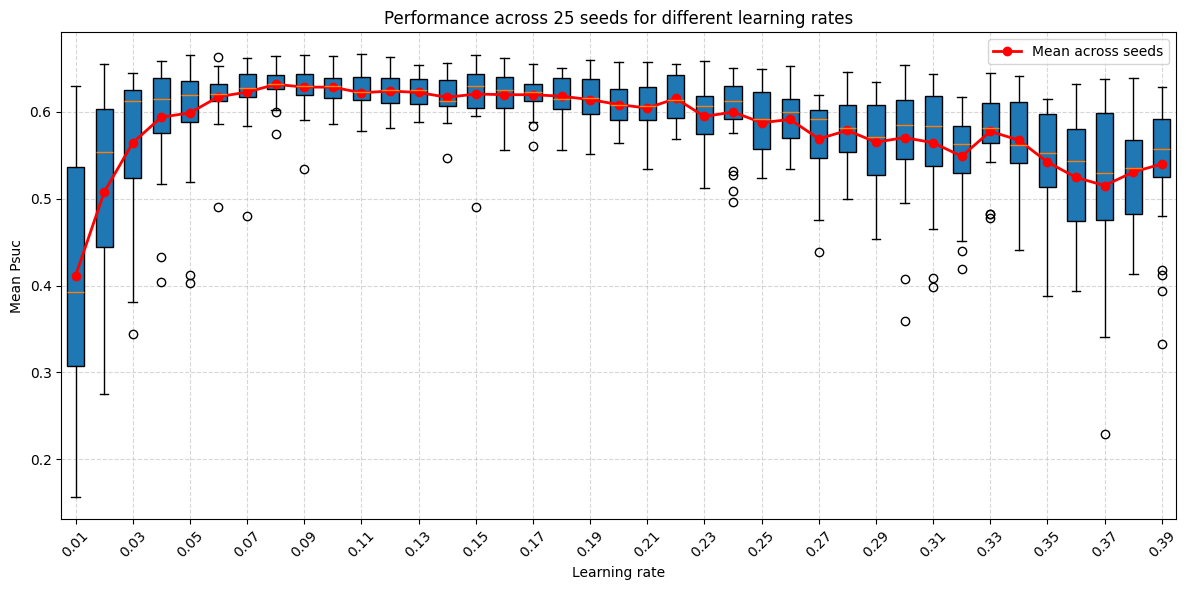

Best learning rate: 0.08 with mean Psuc = 0.6318


In [75]:
opt_lr_qfl_s4_setup1o = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [76]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 10

lr_values = [opt_lr_qfl_s4_setup1o]
seeds = np.arange(1000, 1100)

In [77]:
QFL_Psucs_s4_setup1o = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 10
 - lr: [np.float64(0.08)]
Seed #1000
Seed #1010
Seed #1020
Seed #1030
Seed #1040
Seed #1050
Seed #1060
Seed #1070
Seed #1080
Seed #1090


In [78]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=123,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()

run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=opt_lr_qfl_s4_setup1o, 
                                   local_batch_size=local_batch_size)

client = clients[0]
client.get_thetas()

array([2.4834188 , 1.51415355, 3.66892933, 3.84131479, 3.28211732,
       2.16600827, 3.54680734, 2.71745062, 2.79560153, 2.84823996,
       5.19755563, 3.32179488])


Test accuracy: 0.643
Confusion matrix (counts):
 [[1819  652  905]
 [ 188 2996  120]
 [ 914  792 1614]]


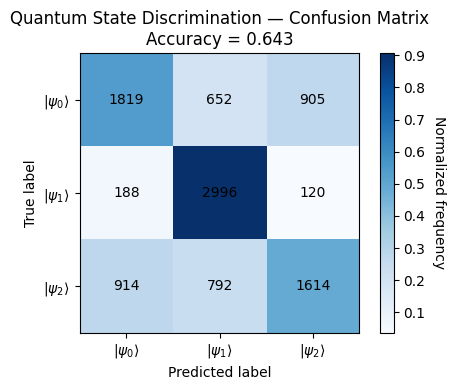

In [79]:
num_test_samples = 10000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [80]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 1, 31, 18, 45, 0, 448192)

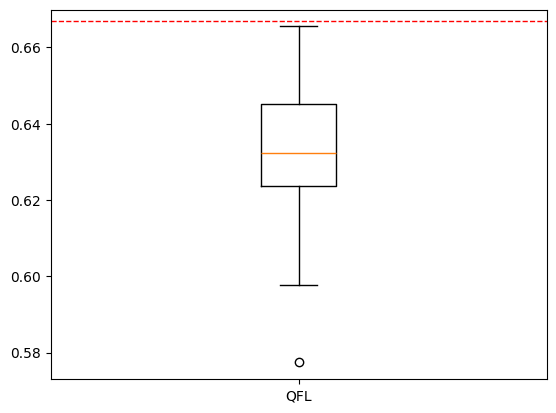

In [81]:
plt.boxplot([QFL_Psucs_s4_setup1o.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [82]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [83]:
all_mean_Psucs, all_min_Psucs, _ = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24


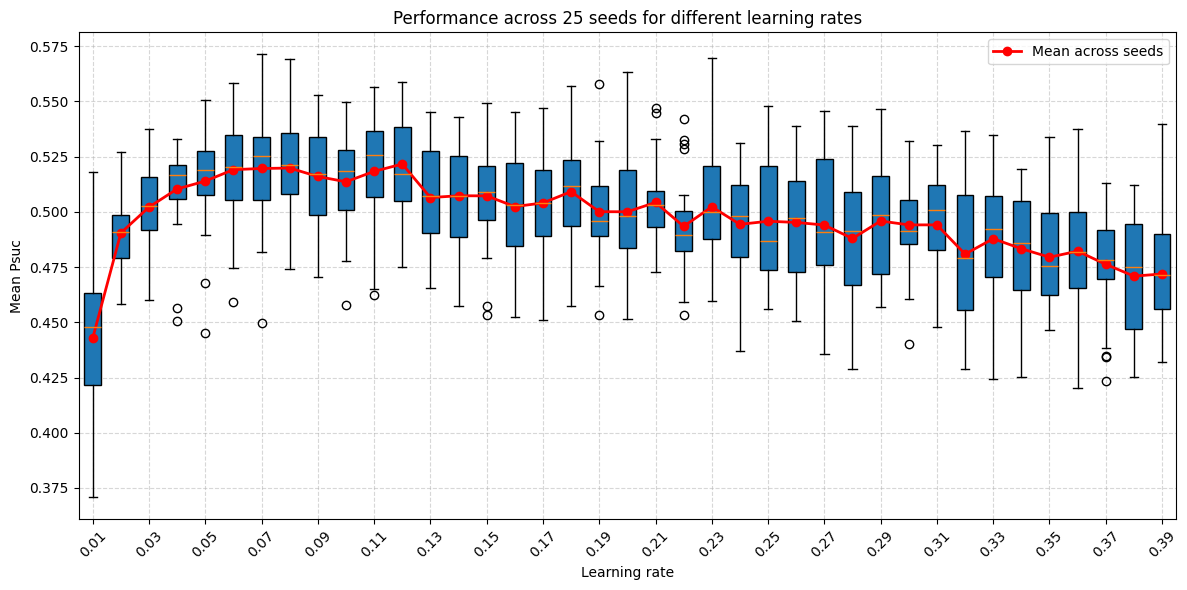

Best learning rate: 0.12 with mean Psuc = 0.5216


In [84]:
opt_lr_1s_s4_setup1o = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [85]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s4_setup1o]
seeds = np.arange(0, 100)

In [86]:
all_mean_Psucs_1s_s4_setup1o, all_min_Psucs_1s_s4_setup1o, last_thetas = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 10
 - Num Samples: 50
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [np.float64(0.12)]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24
Seed #25
Seed #26
Seed #27
Seed #28
Seed #29
Seed #30
Seed #31
Seed #32
Seed #33
Seed #34
Seed #35
Seed #36
Seed #37
Seed #38
Seed #39
Seed #40
Seed #41
Seed #42
Seed #43
Seed #44
Seed #45
Seed #46
Seed #47
Seed #48
Seed #49
Seed #50
Seed #51
Seed #52
Seed #53
Seed #54
Seed #55
Seed #56
Seed #57
Seed #58
Seed #59
Seed #60
Seed #61
Seed #62
Seed #63
Seed #64
Seed #65
Seed #66
Seed #67
Seed #68
Seed #69
Seed #70
Seed #71
Seed #72
Seed #73
Seed #74
Seed #75
Seed #76
Seed #77
Seed #78
Seed #79
Seed #80
Seed #81
Seed #82
Seed #83
Seed #84
Seed #85
Seed #86
Seed #87
Seed #88
Seed #89
Seed #90
Seed #91
Seed #92
Seed #93
Seed #94
Seed #95
Seed #96
Seed #97
Seed #98

/home/rocco/QFL/nb/State-Discrimination/.qsd-venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


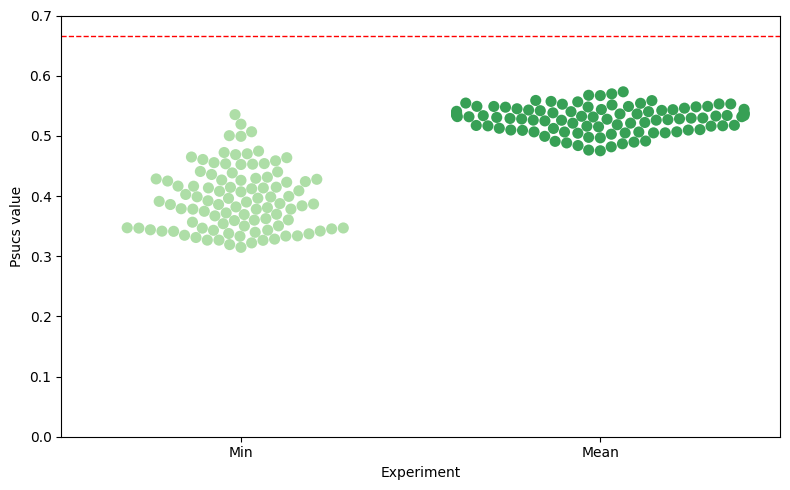

In [87]:
df = pd.DataFrame({
    "Psucs": np.concatenate([all_min_Psucs_1s_s4_setup1o.flatten(), all_mean_Psucs_1s_s4_setup1o.flatten()]),
    "Experiment": ["Min"] * len(all_min_Psucs_1s_s4_setup1o.flatten()) + ["Mean"] * len(all_mean_Psucs_1s_s4_setup1o.flatten())
})

plt.figure(figsize=(8, 5))
sns.swarmplot(
    x="Experiment", 
    y="Psucs", 
    hue="Experiment", 
    data=df, 
    palette="Greens", 
    size=8, 
    legend=False  # suppress the redundant legend
)

plt.axhline(y=2/3, color='r', linestyle='--', linewidth=1)
plt.ylim(0.0, 0.7)
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.tight_layout()
plt.show()


In [88]:
np.mean(all_mean_Psucs_1s_s4_setup1o)

np.float64(0.5276212)

In [89]:
last_thetas[0]

array([4.5590831 , 3.33417468, 4.02076876, 2.17631221, 3.95909177,
       3.69819575, 5.29556321, 3.45973617, 2.37502029, 5.46869192,
       2.68267531, 2.83925335])

In [90]:
test_client = Client(None, None, None)
test_client.set_thetas(last_thetas[0])
# test_client.set_thetas(np.mean(last_thetas, axis=0))
compute_Psuccess(test_client)

0.5142843333333333

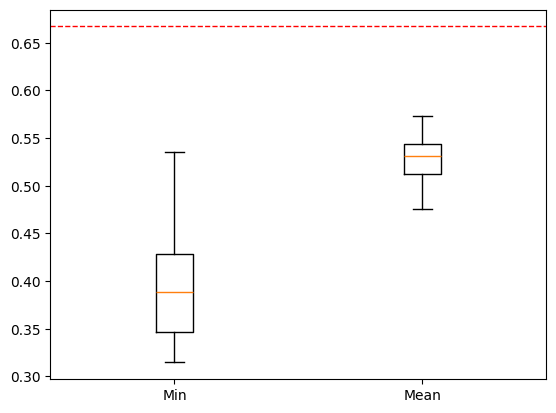

In [91]:
plt.boxplot([all_min_Psucs_1s_s4_setup1o.flatten(), all_mean_Psucs_1s_s4_setup1o.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

In [92]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=42,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()
    client.local_train(batch_size=len(client.labels), lr=opt_lr_1s_s4_setup1o)

client = clients[0]
client.get_thetas()

array([5.91262734, 4.30901942, 2.93515268, 1.28271094, 0.25574489,
       0.68853978, 6.08093464, 4.13091523, 4.09368827, 0.31326451,
       7.00454766, 5.23532634])


Test accuracy: 0.574
Confusion matrix (counts):
 [[263  12  68]
 [230   2 112]
 [  2   2 309]]


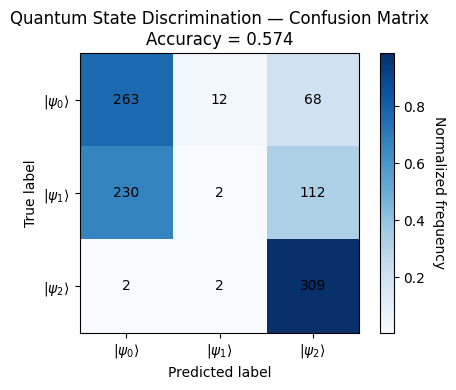

In [93]:
num_test_samples = 1000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


#### Comparisons

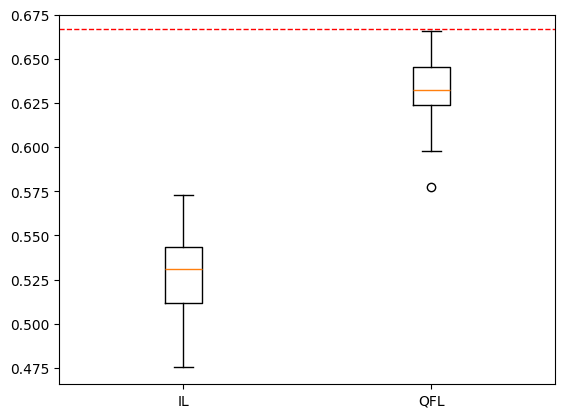

In [94]:
plt.boxplot([all_mean_Psucs_1s_s4_setup1o.flatten(), QFL_Psucs_s4_setup1o.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

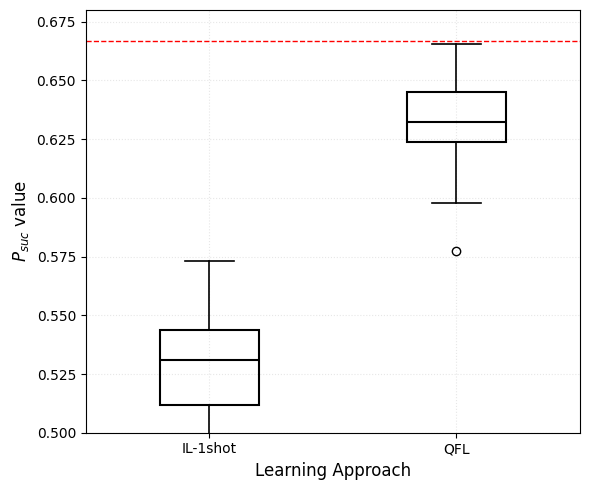

In [95]:
# Data
data = [all_mean_Psucs_1s_s4_setup1o.flatten(), QFL_Psucs_s4_setup1o.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.6667, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("trine_setup1_sigma1.png", dpi=600, bbox_inches="tight")
plt.show()

In [96]:
print(np.mean(all_mean_Psucs_1s_s4_setup1o))
print(np.mean(QFL_Psucs_s4_setup1o))

0.5276212
0.6332680000000002


In [97]:
print(np.min(all_mean_Psucs_1s_s4_setup1o), np.max(all_mean_Psucs_1s_s4_setup1o))
print(np.min(QFL_Psucs_s4_setup1o), np.max(QFL_Psucs_s4_setup1o))

0.47523 0.57318
0.5774 0.6655


## Setup 4 (x5): 25 clients, 5x5 = 25 samples

In [219]:
num_clients = 25
num_samples = 25

### $\sigma=4.0$

In [99]:
sigma_range = (4.0, 4.0)

#### QFL

In [100]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [101]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 1, 31, 21, 51, 2, 60827)

In [102]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


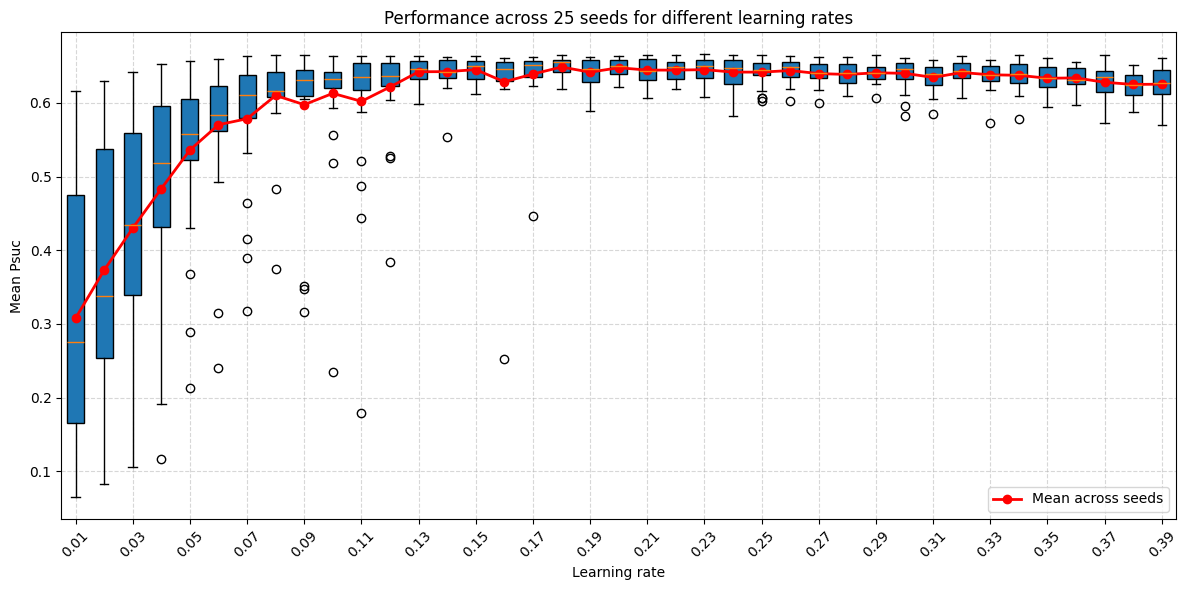

Best learning rate: 0.18 with mean Psuc = 0.6488


In [103]:
opt_lr_qfl_s4_setup4 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [104]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [opt_lr_qfl_s4_setup4]
seeds = np.arange(1000, 1100)

In [105]:
QFL_Psucs_s4_setup4 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [np.float64(0.18)]
Seed #1000
Seed #1010
Seed #1020
Seed #1030
Seed #1040
Seed #1050
Seed #1060
Seed #1070
Seed #1080
Seed #1090


In [106]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=123,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()

run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=opt_lr_qfl_s4_setup4, 
                                   local_batch_size=local_batch_size)

client = clients[0]
client.get_thetas()

array([5.08776162, 4.86363515, 0.97312443, 3.38006351, 4.31414881,
       1.84065838, 3.58234113, 1.09731127, 2.99755441, 2.87380308,
       1.71680982, 5.61023263])


Test accuracy: 0.645
Confusion matrix (counts):
 [[1748  853  753]
 [ 137 2980  194]
 [ 936  673 1726]]


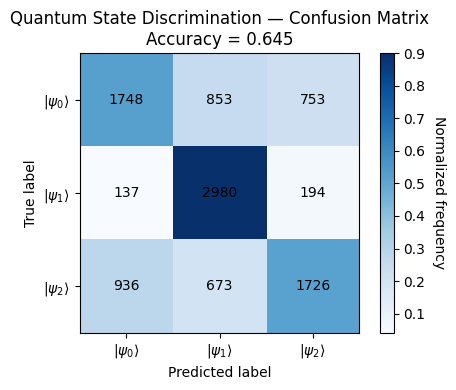

In [107]:
num_test_samples = 10000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [108]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 1, 1, 32, 16, 132994)

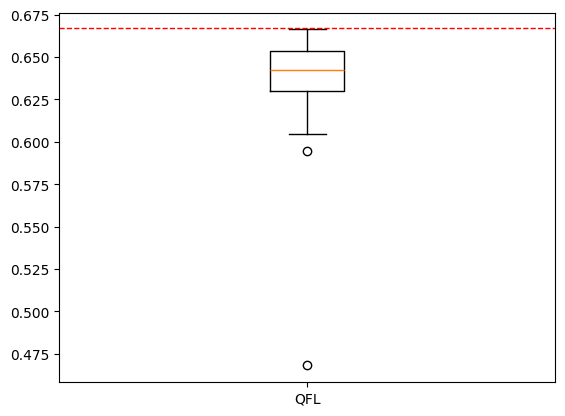

In [109]:
plt.boxplot([QFL_Psucs_s4_setup4.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [110]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [111]:
all_mean_Psucs, all_min_Psucs, _ = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24


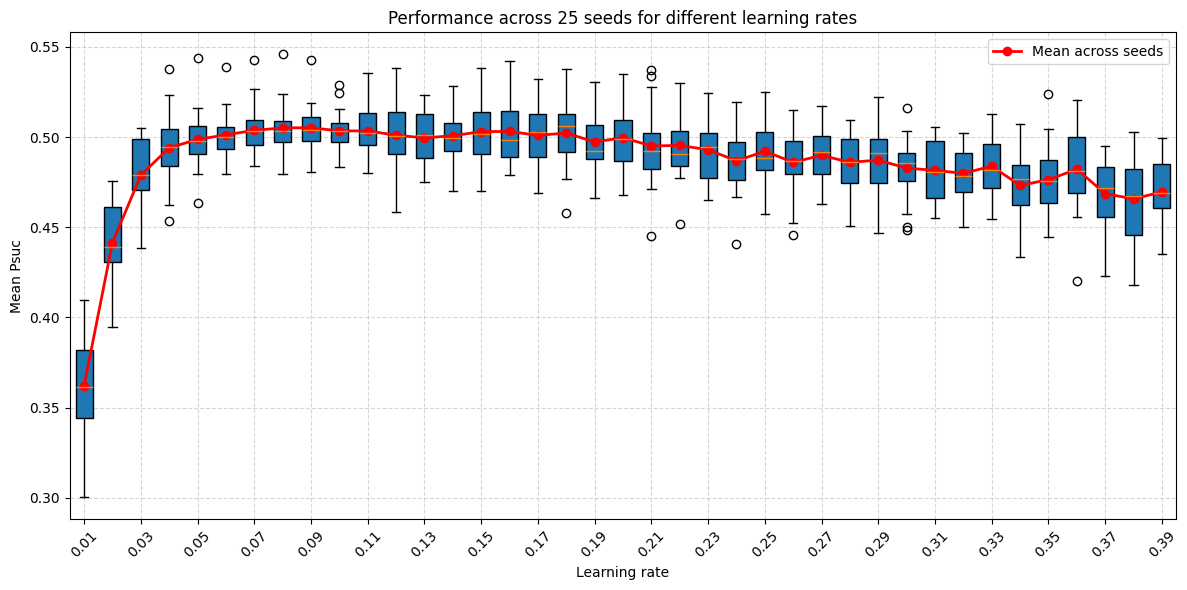

Best learning rate: 0.09 with mean Psuc = 0.5052


In [112]:
opt_lr_1s_s4_setup4 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [113]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s4_setup4]
seeds = np.arange(0, 100)

In [114]:
all_mean_Psucs_1s_s4_setup4, all_min_Psucs_1s_s4_setup4, last_thetas = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [np.float64(0.09)]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24
Seed #25
Seed #26
Seed #27
Seed #28
Seed #29
Seed #30
Seed #31
Seed #32
Seed #33
Seed #34
Seed #35
Seed #36
Seed #37
Seed #38
Seed #39
Seed #40
Seed #41
Seed #42
Seed #43
Seed #44
Seed #45
Seed #46
Seed #47
Seed #48
Seed #49
Seed #50
Seed #51
Seed #52
Seed #53
Seed #54
Seed #55
Seed #56
Seed #57
Seed #58
Seed #59
Seed #60
Seed #61
Seed #62
Seed #63
Seed #64
Seed #65
Seed #66
Seed #67
Seed #68
Seed #69
Seed #70
Seed #71
Seed #72
Seed #73
Seed #74
Seed #75
Seed #76
Seed #77
Seed #78
Seed #79
Seed #80
Seed #81
Seed #82
Seed #83
Seed #84
Seed #85
Seed #86
Seed #87
Seed #88
Seed #89
Seed #90
Seed #91
Seed #92
Seed #93
Seed #94
Seed #95
Seed #96
Seed #97
Seed #98

/home/rocco/QFL/nb/State-Discrimination/.qsd-venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rocco/QFL/nb/State-Discrimination/.qsd-venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


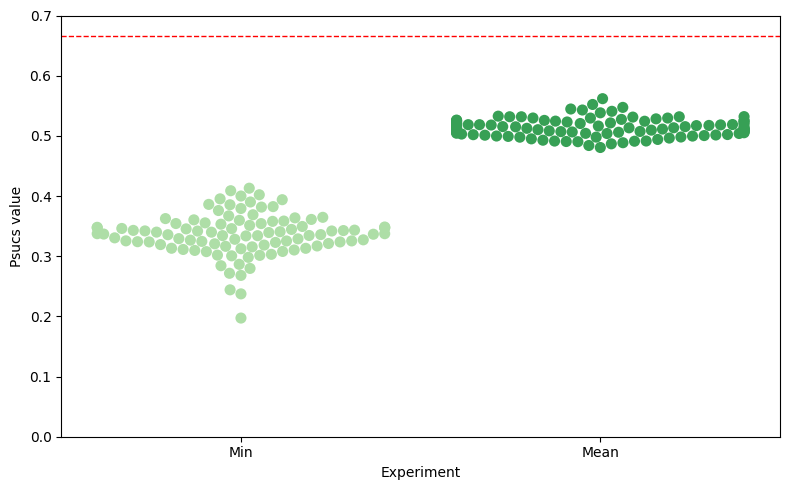

In [115]:
df = pd.DataFrame({
    "Psucs": np.concatenate([all_min_Psucs_1s_s4_setup4.flatten(), all_mean_Psucs_1s_s4_setup4.flatten()]),
    "Experiment": ["Min"] * len(all_min_Psucs_1s_s4_setup4.flatten()) + ["Mean"] * len(all_mean_Psucs_1s_s4_setup4.flatten())
})

plt.figure(figsize=(8, 5))
sns.swarmplot(
    x="Experiment", 
    y="Psucs", 
    hue="Experiment", 
    data=df, 
    palette="Greens", 
    size=8, 
    legend=False  # suppress the redundant legend
)

plt.axhline(y=2/3, color='r', linestyle='--', linewidth=1)
plt.ylim(0.0, 0.7)
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.tight_layout()
plt.show()


In [116]:
np.mean(all_mean_Psucs_1s_s4_setup4)

np.float64(0.5135494)

In [117]:
last_thetas[0]

array([5.38619924, 2.661712  , 3.63877176, 2.2263105 , 4.03035199,
       3.76584742, 5.14331443, 5.59409207, 2.39036417, 5.25661516,
       3.96194176, 4.35090418])

In [118]:
test_client = Client(None, None, None)
test_client.set_thetas(last_thetas[0])
# test_client.set_thetas(np.mean(last_thetas, axis=0))
compute_Psuccess(test_client)

0.5089876666666666

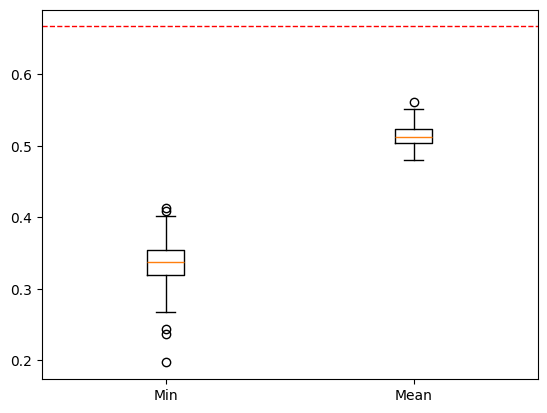

In [119]:
plt.boxplot([all_min_Psucs_1s_s4_setup4.flatten(), all_mean_Psucs_1s_s4_setup4.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

In [120]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=42,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()
    client.local_train(batch_size=len(client.labels), lr=opt_lr_1s_s4_setup4)

client = clients[0]
client.get_thetas()

array([5.76622641, 4.3780244 , 3.4686323 , 1.53784766, 1.1850053 ,
       0.27283504, 5.72572836, 3.64181685, 4.73021391, 0.73313759,
       6.42143473, 4.77642279])


Test accuracy: 0.616
Confusion matrix (counts):
 [[319   9   5]
 [101  12 220]
 [ 49   0 285]]


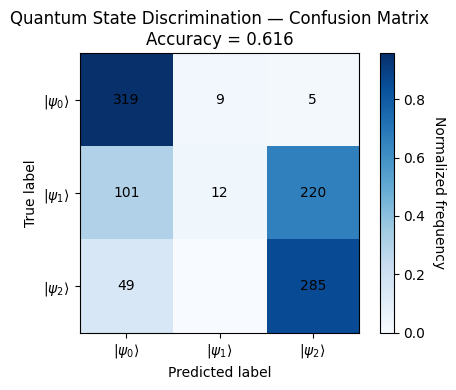

In [121]:
num_test_samples = 1000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


#### Comparisons

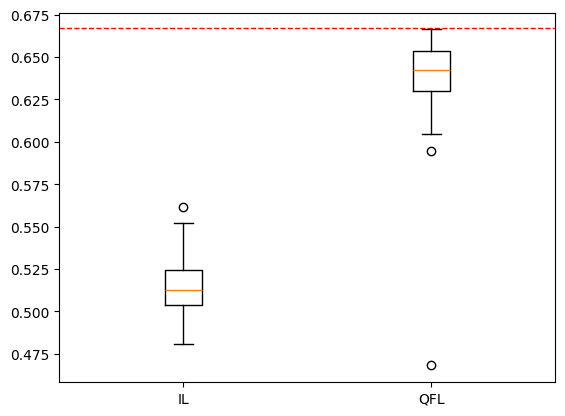

In [122]:
plt.boxplot([all_mean_Psucs_1s_s4_setup4.flatten(), QFL_Psucs_s4_setup4.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

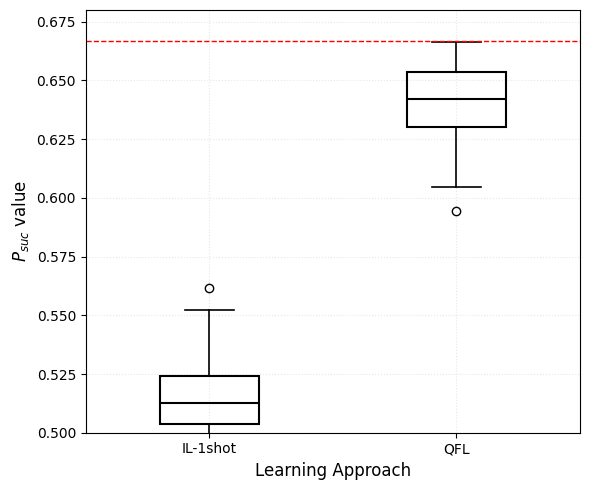

In [123]:
# Data
data = [all_mean_Psucs_1s_s4_setup4.flatten(), QFL_Psucs_s4_setup4.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.6667, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("trine_setup1_sigma1.png", dpi=600, bbox_inches="tight")
plt.show()

In [124]:
print(np.mean(all_mean_Psucs_1s_s4_setup4))
print(np.mean(QFL_Psucs_s4_setup4))

0.5135494
0.639115


In [125]:
print(np.min(all_mean_Psucs_1s_s4_setup4), np.max(all_mean_Psucs_1s_s4_setup4))
print(np.min(QFL_Psucs_s4_setup4), np.max(QFL_Psucs_s4_setup4))

0.48064 0.561784
0.4681 0.6662


### $\sigma=1.0$

In [220]:
sigma_range = (1.0, 1.0)

#### QFL

In [127]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [128]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 1, 5, 38, 12, 396318)

In [129]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


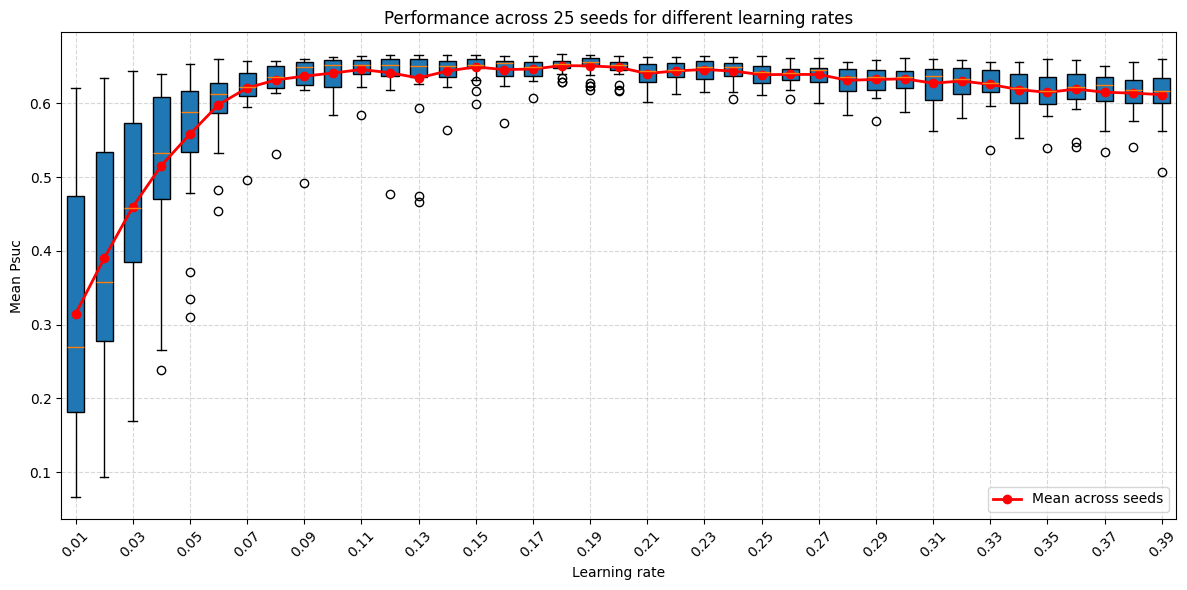

Best learning rate: 0.18 with mean Psuc = 0.6513


In [130]:
opt_lr_qfl_s1_setup4 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [221]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [opt_lr_qfl_s1_setup4]
seeds = np.arange(0, 100)

In [222]:
QFL_Psucs_s1_setup4 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.18]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [224]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=123,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()

run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=opt_lr_qfl_s1_setup4, 
                                   local_batch_size=local_batch_size)

client = clients[0]
client.get_thetas()

array([5.42497363, 3.71751623, 2.61389082, 2.48105332, 3.75407501,
       1.8394074 , 2.85753999, 0.56461285, 3.07107366, 3.38331561,
       4.25804457, 6.03716774])


Test accuracy: 0.644
Confusion matrix (counts):
 [[2797  396  161]
 [ 216 2855  240]
 [1444 1105  786]]


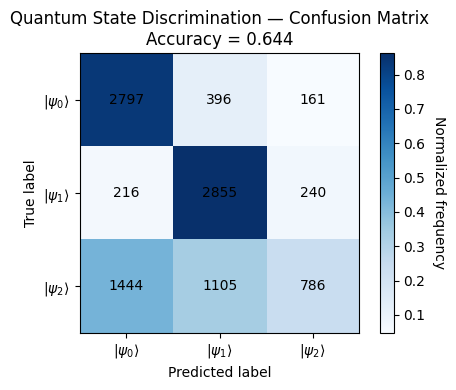

In [225]:
num_test_samples = 10000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [226]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 3, 11, 33, 8, 382634)

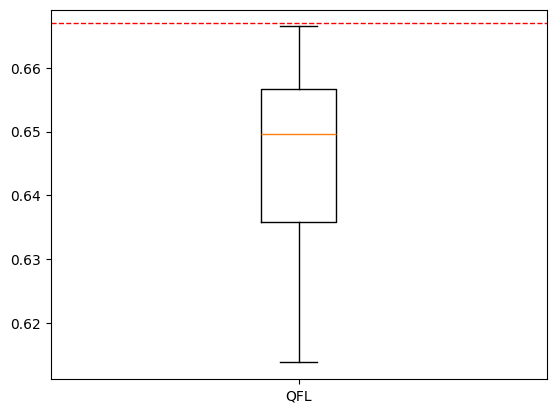

In [227]:
plt.boxplot([QFL_Psucs_s1_setup4.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [137]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [138]:
all_mean_Psucs, all_min_Psucs, _ = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24


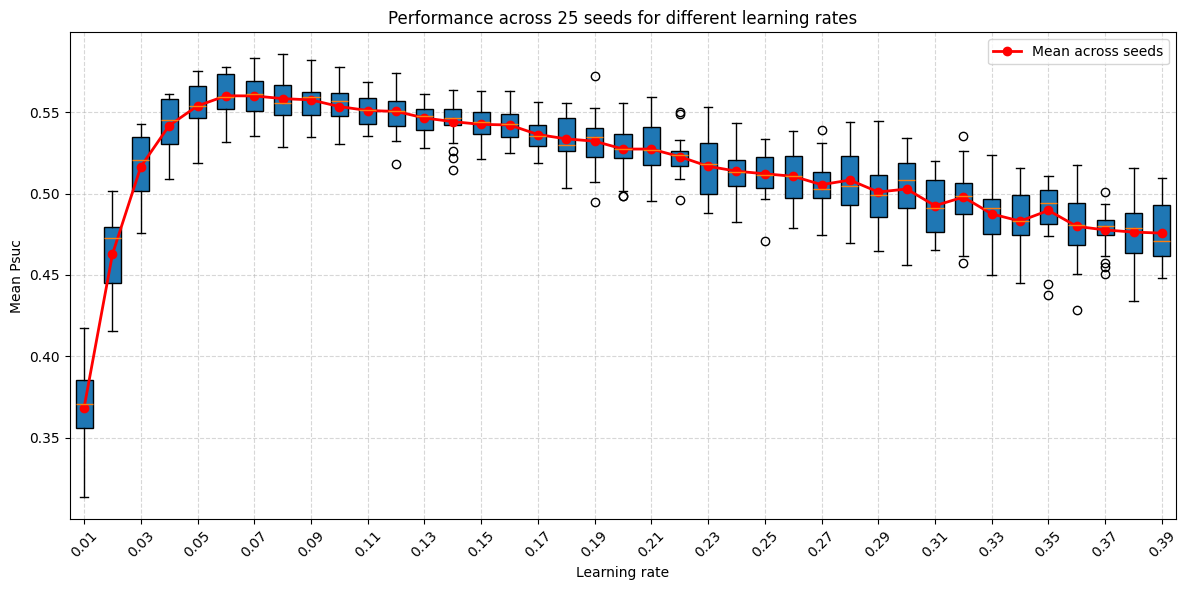

Best learning rate: 0.06 with mean Psuc = 0.5600


In [139]:
opt_lr_1s_s1_setup4 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [140]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s1_setup4]
seeds = np.arange(0, 100)

In [141]:
all_mean_Psucs_1s_s1_setup4, all_min_Psucs_1s_s1_setup4, last_thetas = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 25
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [np.float64(0.06)]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24
Seed #25
Seed #26
Seed #27
Seed #28
Seed #29
Seed #30
Seed #31
Seed #32
Seed #33
Seed #34
Seed #35
Seed #36
Seed #37
Seed #38
Seed #39
Seed #40
Seed #41
Seed #42
Seed #43
Seed #44
Seed #45
Seed #46
Seed #47
Seed #48
Seed #49
Seed #50
Seed #51
Seed #52
Seed #53
Seed #54
Seed #55
Seed #56
Seed #57
Seed #58
Seed #59
Seed #60
Seed #61
Seed #62
Seed #63
Seed #64
Seed #65
Seed #66
Seed #67
Seed #68
Seed #69
Seed #70
Seed #71
Seed #72
Seed #73
Seed #74
Seed #75
Seed #76
Seed #77
Seed #78
Seed #79
Seed #80
Seed #81
Seed #82
Seed #83
Seed #84
Seed #85
Seed #86
Seed #87
Seed #88
Seed #89
Seed #90
Seed #91
Seed #92
Seed #93
Seed #94
Seed #95
Seed #96
Seed #97
Seed #98

/home/rocco/QFL/nb/State-Discrimination/.qsd-venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


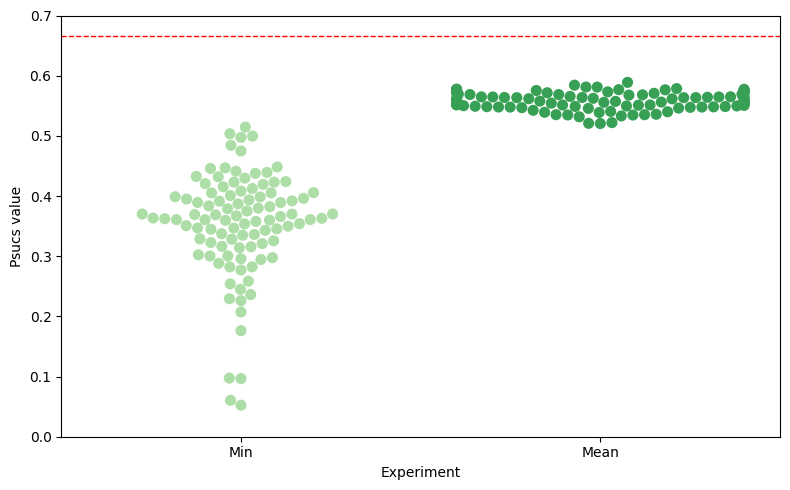

In [142]:
df = pd.DataFrame({
    "Psucs": np.concatenate([all_min_Psucs_1s_s1_setup4.flatten(), all_mean_Psucs_1s_s1_setup4.flatten()]),
    "Experiment": ["Min"] * len(all_min_Psucs_1s_s1_setup4.flatten()) + ["Mean"] * len(all_mean_Psucs_1s_s1_setup4.flatten())
})

plt.figure(figsize=(8, 5))
sns.swarmplot(
    x="Experiment", 
    y="Psucs", 
    hue="Experiment", 
    data=df, 
    palette="Greens", 
    size=8, 
    legend=False  # suppress the redundant legend
)

plt.axhline(y=2/3, color='r', linestyle='--', linewidth=1)
plt.ylim(0.0, 0.7)
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.tight_layout()
plt.show()


In [143]:
np.mean(all_mean_Psucs_1s_s1_setup4)

np.float64(0.55827296)

In [144]:
last_thetas[0]

array([5.38586774, 3.27103725, 3.36071814, 2.17283874, 3.63967398,
       3.37130415, 5.49601972, 5.78152523, 1.85079266, 5.55790804,
       3.81335225, 3.73094816])

In [145]:
test_client = Client(None, None, None)
test_client.set_thetas(last_thetas[0])
# test_client.set_thetas(np.mean(last_thetas, axis=0))
compute_Psuccess(test_client)

0.6073463333333333

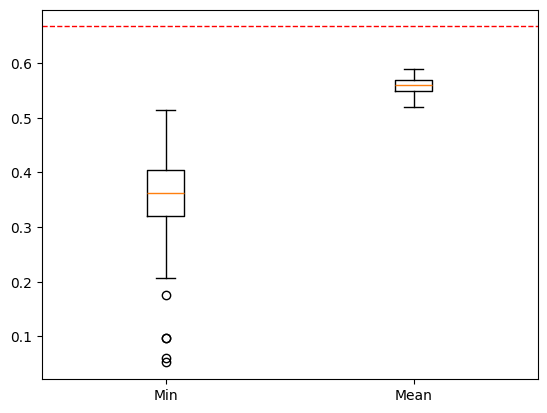

In [146]:
plt.boxplot([all_min_Psucs_1s_s1_setup4.flatten(), all_mean_Psucs_1s_s1_setup4.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

In [147]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=42,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()
    client.local_train(batch_size=len(client.labels), lr=opt_lr_1s_s1_setup4)

client = clients[0]
client.get_thetas()

array([5.83991081, 4.3468154 , 3.50254214, 1.33807371, 1.11540704,
       0.36081921, 5.59850697, 3.46680749, 4.42553376, 0.47194854,
       6.41563209, 5.06149318])


Test accuracy: 0.541
Confusion matrix (counts):
 [[333   0   0]
 [118   1 214]
 [123   4 207]]


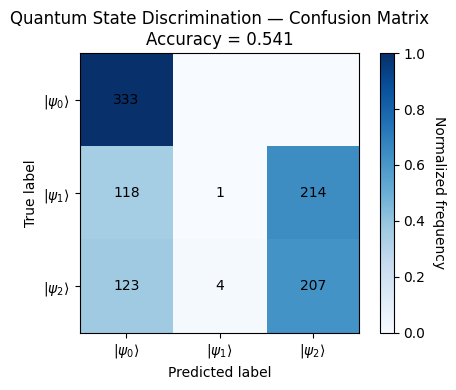

In [148]:
num_test_samples = 1000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


#### Comparisons

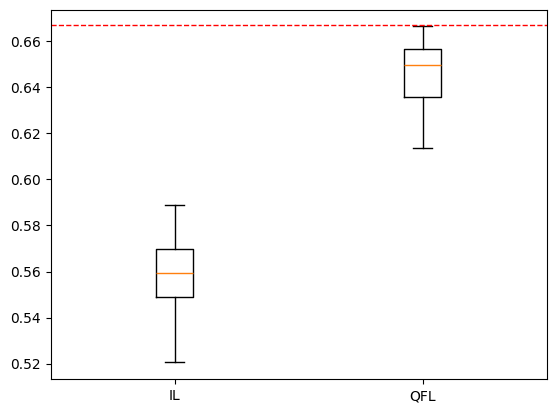

In [228]:
plt.boxplot([all_mean_Psucs_1s_s1_setup4.flatten(), QFL_Psucs_s1_setup4.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

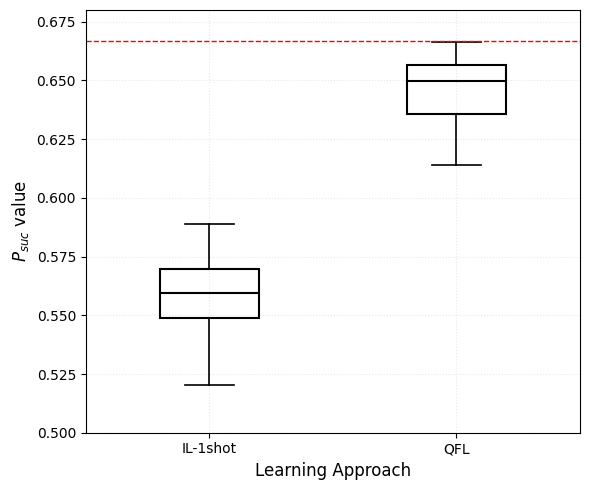

In [229]:
# Data
data = [all_mean_Psucs_1s_s1_setup4.flatten(), QFL_Psucs_s1_setup4.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.6667, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("trine_setup1_sigma1.png", dpi=600, bbox_inches="tight")
plt.show()

In [230]:
print(np.mean(all_mean_Psucs_1s_s1_setup4))
print(np.mean(QFL_Psucs_s1_setup4))

0.55827296
0.6452789999999999


In [231]:
print(np.min(all_mean_Psucs_1s_s1_setup4), np.max(all_mean_Psucs_1s_s1_setup4))
print(np.min(QFL_Psucs_s1_setup4), np.max(QFL_Psucs_s1_setup4))

0.520464 0.588876
0.6138 0.6665


## Setup 5 (x5): 50 clients, 5x5 = 25 samples

In [232]:
num_clients = 50
num_samples = 25

### $\sigma=4.0$

In [154]:
sigma_range = (4.0, 4.0)

#### QFL

In [155]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [156]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 1, 13, 26, 11, 324647)

In [157]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


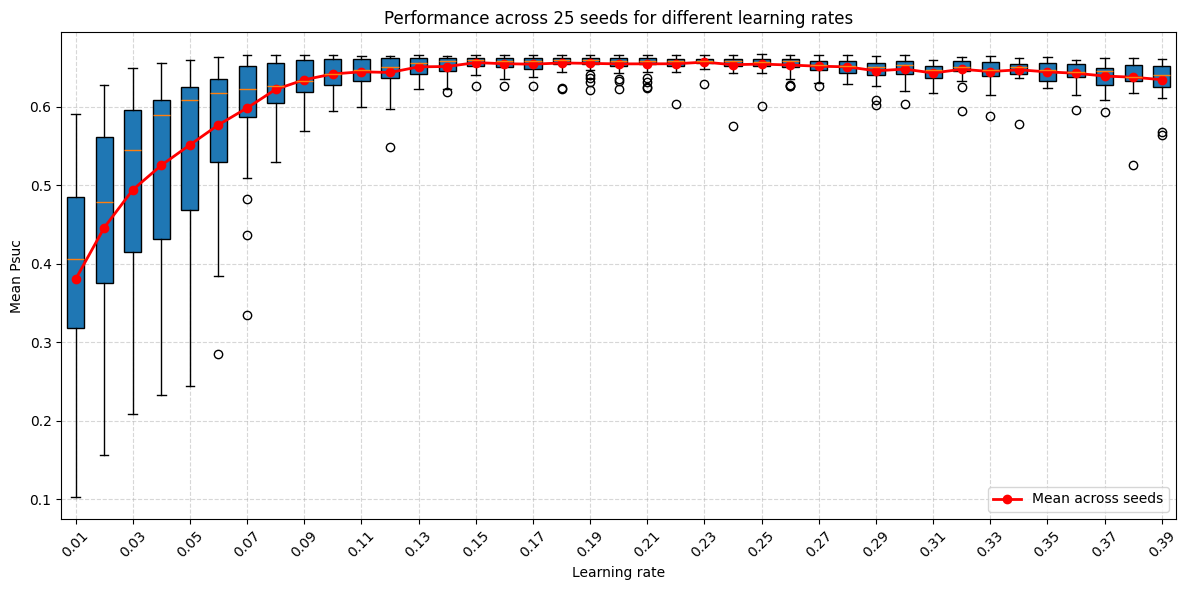

Best learning rate: 0.23 with mean Psuc = 0.6565


In [158]:
opt_lr_qfl_s4_setup5 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [159]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [opt_lr_qfl_s4_setup5]
seeds = np.arange(1000, 1100)

In [160]:
QFL_Psucs_s4_setup5 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [np.float64(0.23)]
Seed #1000
Seed #1010
Seed #1020
Seed #1030
Seed #1040
Seed #1050
Seed #1060
Seed #1070
Seed #1080
Seed #1090


In [161]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=123,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()

run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=opt_lr_qfl_s4_setup5, 
                                   local_batch_size=local_batch_size)

client = clients[0]
client.get_thetas()

array([5.28608226, 3.98518821, 5.56241495, 1.98877641, 4.03584262,
       1.05054203, 1.24927277, 1.56024543, 3.28393081, 3.76826433,
       3.43294129, 4.85143491])


Test accuracy: 0.661
Confusion matrix (counts):
 [[1865  695  824]
 [ 494 2520  358]
 [ 441  577 2226]]


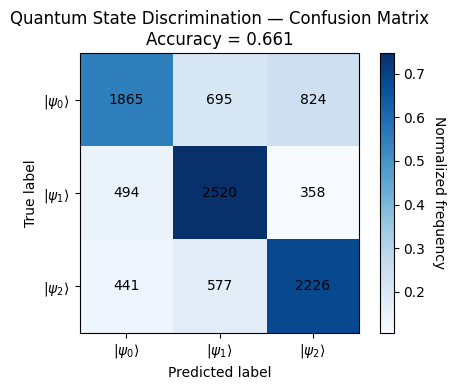

In [162]:
num_test_samples = 10000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [163]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 1, 20, 47, 47, 315389)

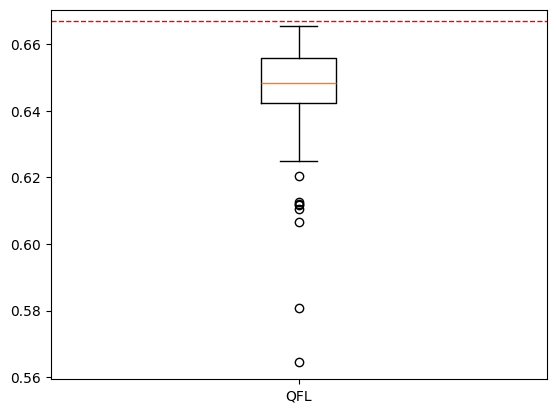

In [164]:
plt.boxplot([QFL_Psucs_s4_setup5.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [165]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [166]:
all_mean_Psucs, all_min_Psucs, _ = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24


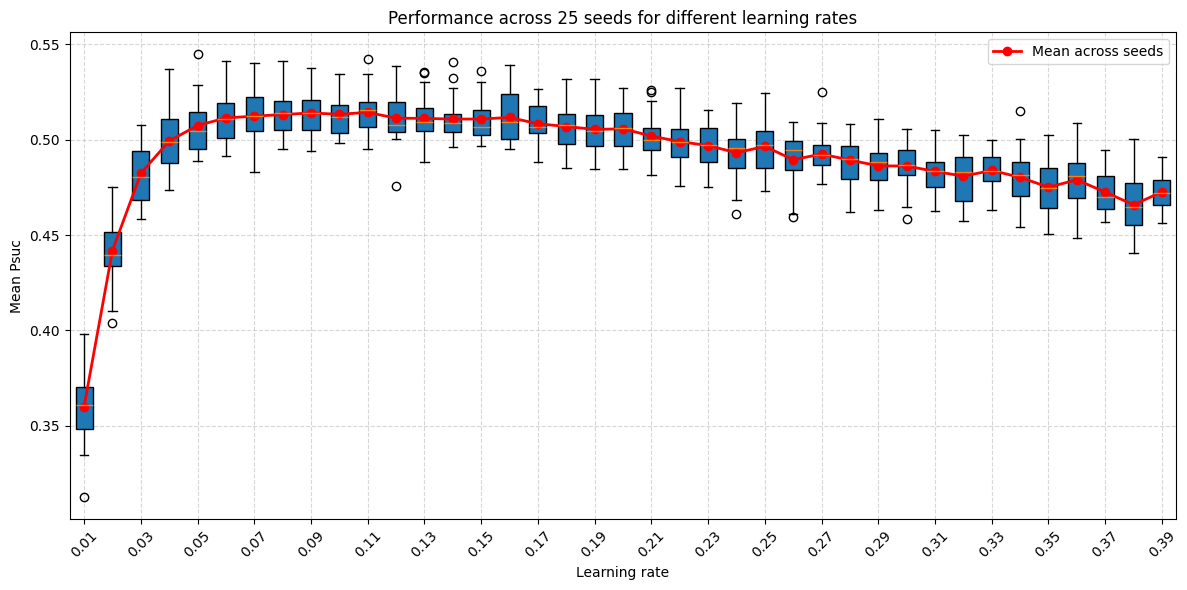

Best learning rate: 0.11 with mean Psuc = 0.5143


In [167]:
opt_lr_1s_s4_setup5 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [168]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s4_setup5]
seeds = np.arange(0, 100)

In [169]:
all_mean_Psucs_1s_s4_setup5, all_min_Psucs_1s_s4_setup5, last_thetas = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (4.0, 4.0)
 - Shots: 1
 - lr: [np.float64(0.11)]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24
Seed #25
Seed #26
Seed #27
Seed #28
Seed #29
Seed #30
Seed #31
Seed #32
Seed #33
Seed #34
Seed #35
Seed #36
Seed #37
Seed #38
Seed #39
Seed #40
Seed #41
Seed #42
Seed #43
Seed #44
Seed #45
Seed #46
Seed #47
Seed #48
Seed #49
Seed #50
Seed #51
Seed #52
Seed #53
Seed #54
Seed #55
Seed #56
Seed #57
Seed #58
Seed #59
Seed #60
Seed #61
Seed #62
Seed #63
Seed #64
Seed #65
Seed #66
Seed #67
Seed #68
Seed #69
Seed #70
Seed #71
Seed #72
Seed #73
Seed #74
Seed #75
Seed #76
Seed #77
Seed #78
Seed #79
Seed #80
Seed #81
Seed #82
Seed #83
Seed #84
Seed #85
Seed #86
Seed #87
Seed #88
Seed #89
Seed #90
Seed #91
Seed #92
Seed #93
Seed #94
Seed #95
Seed #96
Seed #97
Seed #98

/home/rocco/QFL/nb/State-Discrimination/.qsd-venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rocco/QFL/nb/State-Discrimination/.qsd-venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rocco/QFL/nb/State-Discrimination/.qsd-venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


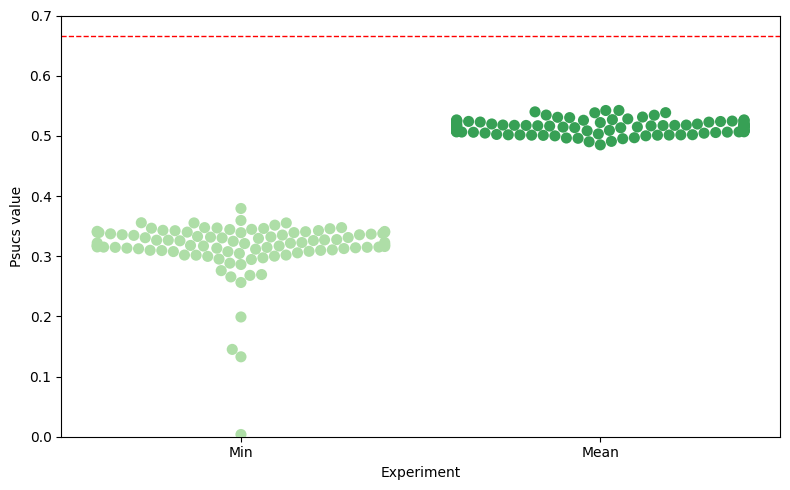

In [170]:
df = pd.DataFrame({
    "Psucs": np.concatenate([all_min_Psucs_1s_s4_setup5.flatten(), all_mean_Psucs_1s_s4_setup5.flatten()]),
    "Experiment": ["Min"] * len(all_min_Psucs_1s_s4_setup5.flatten()) + ["Mean"] * len(all_mean_Psucs_1s_s4_setup5.flatten())
})

plt.figure(figsize=(8, 5))
sns.swarmplot(
    x="Experiment", 
    y="Psucs", 
    hue="Experiment", 
    data=df, 
    palette="Greens", 
    size=8, 
    legend=False  # suppress the redundant legend
)

plt.axhline(y=2/3, color='r', linestyle='--', linewidth=1)
plt.ylim(0.0, 0.7)
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.tight_layout()
plt.show()


In [171]:
np.mean(all_mean_Psucs_1s_s4_setup5)

np.float64(0.5145844199999999)

In [172]:
last_thetas[0]

array([5.21385091, 2.55515078, 3.90048214, 2.21666641, 3.91642451,
       3.49601909, 5.03061685, 5.68285125, 2.46930124, 5.41887782,
       4.35241545, 4.43399578])

In [173]:
test_client = Client(None, None, None)
test_client.set_thetas(last_thetas[0])
# test_client.set_thetas(np.mean(last_thetas, axis=0))
compute_Psuccess(test_client)

0.501971

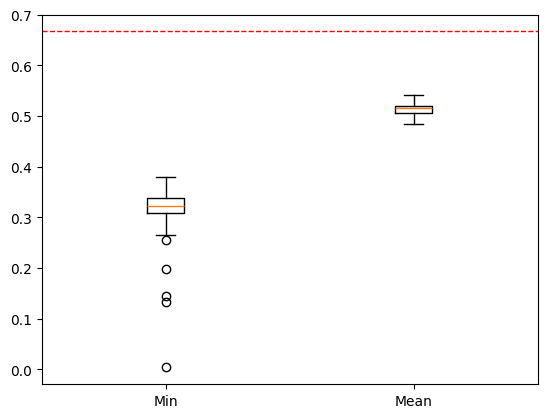

In [174]:
plt.boxplot([all_min_Psucs_1s_s4_setup5.flatten(), all_mean_Psucs_1s_s4_setup5.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

In [175]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=42,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()
    client.local_train(batch_size=len(client.labels), lr=opt_lr_1s_s4_setup5)

client = clients[0]
client.get_thetas()

array([6.07078001, 4.35319016, 3.47655555, 1.14613965, 1.52524661,
       0.39800459, 5.71182182, 3.60148742, 4.792717  , 0.70228392,
       6.63518981, 4.49158453])


Test accuracy: 0.617
Confusion matrix (counts):
 [[326   0  16]
 [150   0 168]
 [ 49   0 291]]


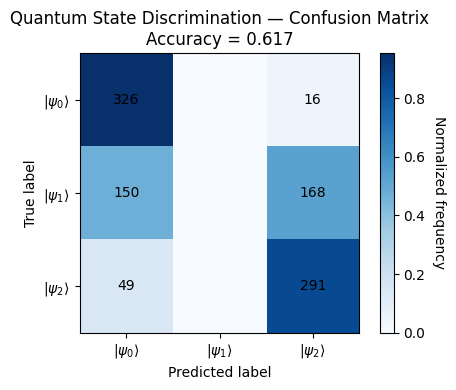

In [176]:
num_test_samples = 1000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


#### Comparisons

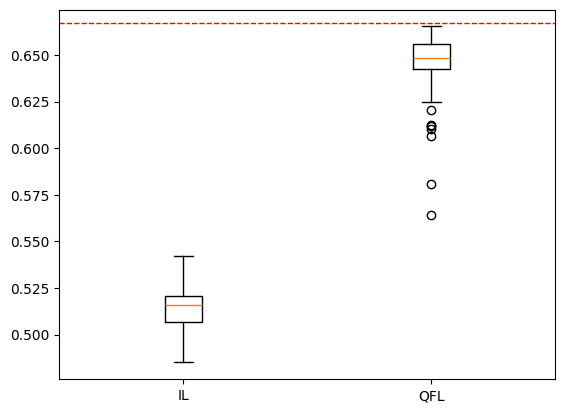

In [177]:
plt.boxplot([all_mean_Psucs_1s_s4_setup5.flatten(), QFL_Psucs_s4_setup5.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

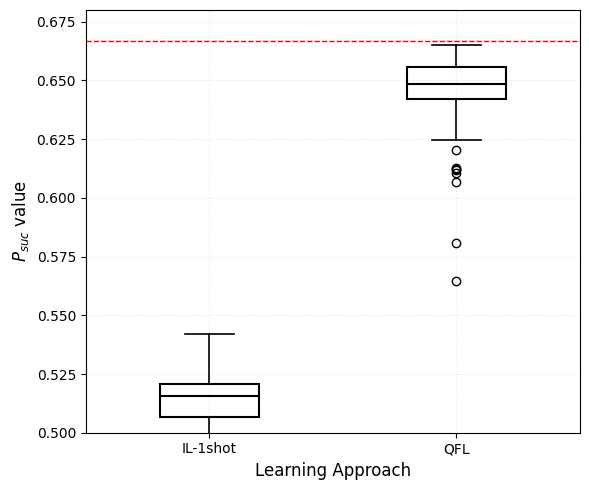

In [178]:
# Data
data = [all_mean_Psucs_1s_s4_setup5.flatten(), QFL_Psucs_s4_setup5.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.6667, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("trine_setup1_sigma1.png", dpi=600, bbox_inches="tight")
plt.show()

In [179]:
print(np.mean(all_mean_Psucs_1s_s4_setup5))
print(np.mean(QFL_Psucs_s4_setup5))

0.5145844199999999
0.6455099999999999


In [180]:
print(np.min(all_mean_Psucs_1s_s4_setup5), np.max(all_mean_Psucs_1s_s4_setup5))
print(np.min(QFL_Psucs_s4_setup5), np.max(QFL_Psucs_s4_setup5))

0.48501 0.542226
0.5644 0.6653


### $\sigma=1.0$

In [233]:
sigma_range = (1.0, 1.0)

#### QFL

In [182]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [183]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 2, 5, 7, 31, 393305)

In [184]:
QFL_Psucs = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #2
Seed #4
Seed #6
Seed #8
Seed #10
Seed #12
Seed #14
Seed #16
Seed #18
Seed #20
Seed #22
Seed #24


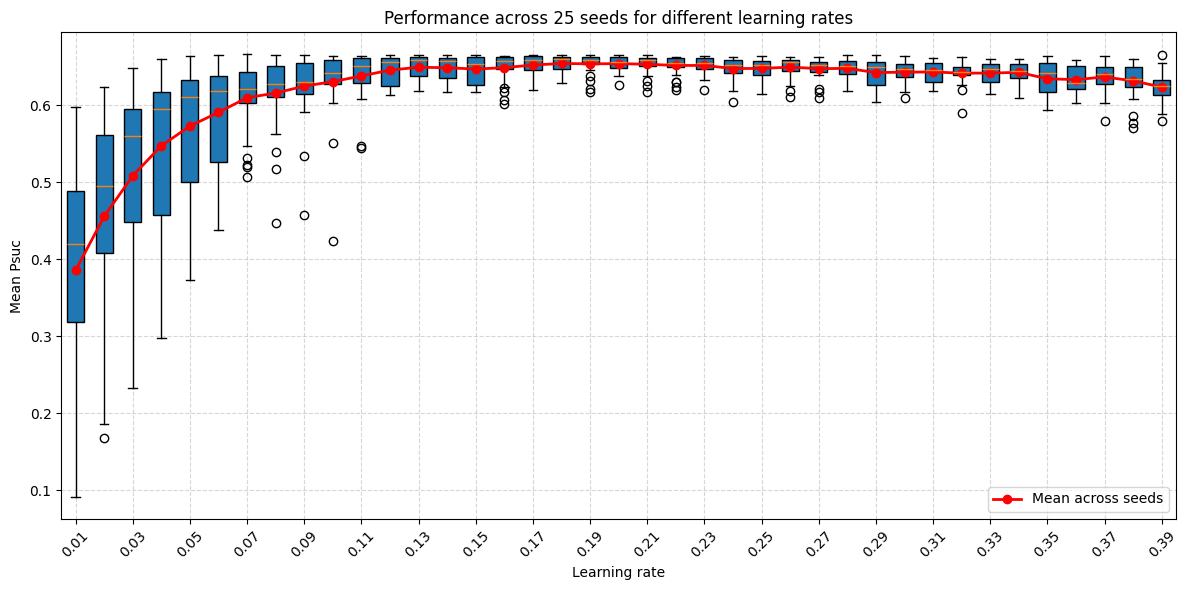

Best learning rate: 0.18 with mean Psuc = 0.6541


In [185]:
opt_lr_qfl_s1_setup5 = compute_optimal_lr(QFL_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [234]:
# SETUP PARAMETER
num_rounds = 5
local_batch_size = 5

lr_values = [opt_lr_qfl_s1_setup5]
seeds = np.arange(0, 100)

In [235]:
QFL_Psucs_s1_setup5 = repeat_ECAI_QFL_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots,
    num_rounds = num_rounds,
    local_batch_size = local_batch_size
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - Number of Rounds: 5
 - Local Batch: 5
 - lr: [0.18]
Seed #0
Seed #10
Seed #20
Seed #30
Seed #40
Seed #50
Seed #60
Seed #70
Seed #80
Seed #90


In [236]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=123,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()

run_federated_training_ECAI(clients, num_rounds=num_rounds, lr=opt_lr_qfl_s1_setup5, 
                                   local_batch_size=local_batch_size)

client = clients[0]
client.get_thetas()

array([5.98228951, 5.53223117, 4.96540279, 2.15132831, 2.51920723,
       1.85215177, 2.24546649, 1.82590241, 3.70826924, 2.70487296,
       3.50509296, 4.83812869])


Test accuracy: 0.660
Confusion matrix (counts):
 [[1598  921  865]
 [ 347 2630  395]
 [ 438  431 2375]]


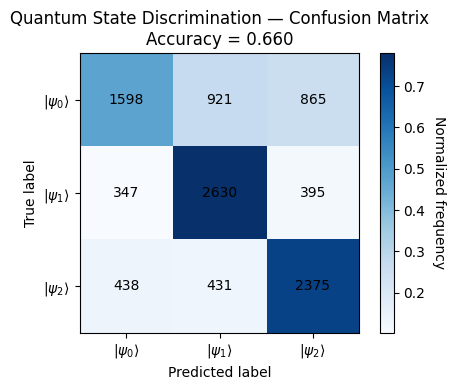

In [237]:
num_test_samples = 10000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [238]:
import datetime
datetime.datetime.now()

datetime.datetime(2026, 2, 3, 12, 17, 39, 519315)

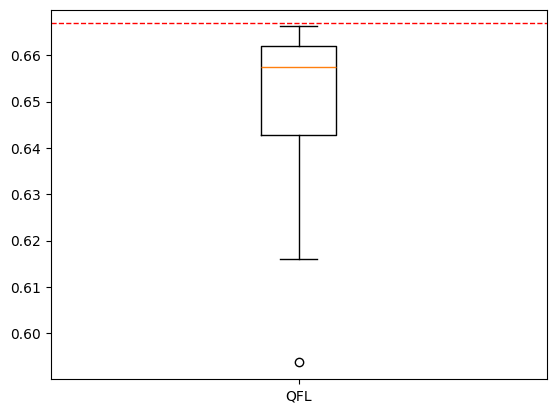

In [239]:
plt.boxplot([QFL_Psucs_s1_setup5.flatten()], tick_labels=["QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

#### Independent Learning

In [192]:
# SETUP PARAMETER

lr_values = np.arange(0.01, 0.40, 0.01)
seeds = np.arange(0, 25)

In [193]:
all_mean_Psucs, all_min_Psucs, _ = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24


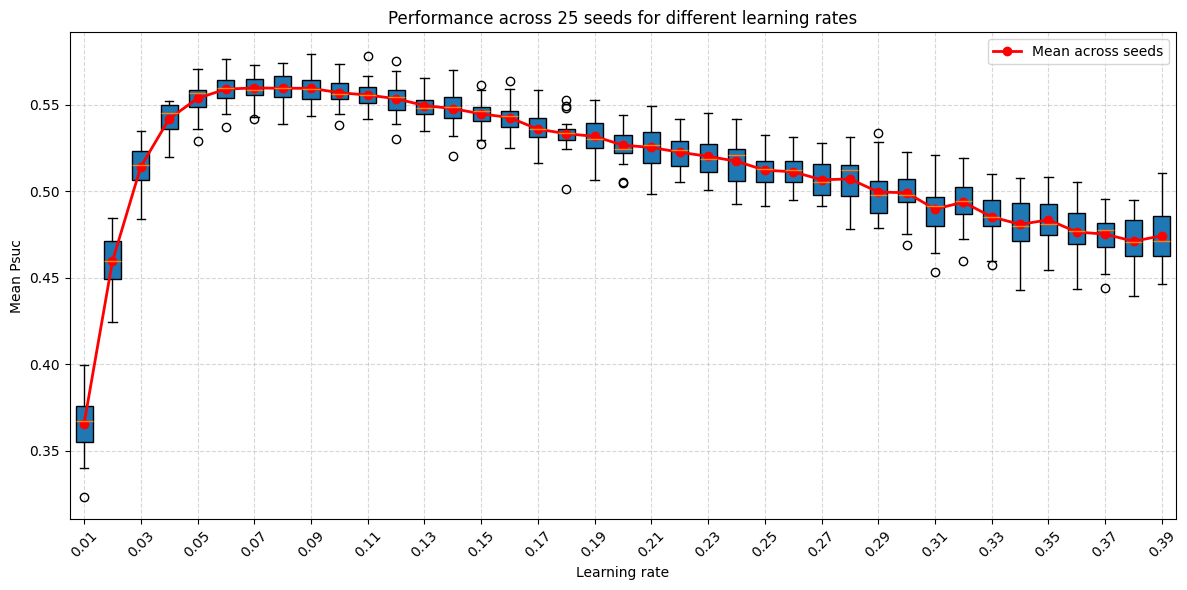

Best learning rate: 0.07 with mean Psuc = 0.5597


In [194]:
opt_lr_1s_s1_setup5 = compute_optimal_lr(all_mean_Psucs, lr_values=lr_values, num_seeds=len(seeds))

In [195]:
# SETUP PARAMETER

lr_values = [opt_lr_1s_s1_setup5]
seeds = np.arange(0, 100)

In [196]:
all_mean_Psucs_1s_s1_setup5, all_min_Psucs_1s_s1_setup5, last_thetas = repeat_setup(
    lr_values = lr_values, 
    seeds = seeds,
    num_clients = num_clients, 
    num_samples = num_samples, 
    sigma_range = sigma_range, 
    n_shots = n_shots, 
)

 ---- SETUP Info ---- 
 - Num Clients: 50
 - Num Samples: 25
 - Sigma: (1.0, 1.0)
 - Shots: 1
 - lr: [np.float64(0.07)]
Seed #0
Seed #1
Seed #2
Seed #3
Seed #4
Seed #5
Seed #6
Seed #7
Seed #8
Seed #9
Seed #10
Seed #11
Seed #12
Seed #13
Seed #14
Seed #15
Seed #16
Seed #17
Seed #18
Seed #19
Seed #20
Seed #21
Seed #22
Seed #23
Seed #24
Seed #25
Seed #26
Seed #27
Seed #28
Seed #29
Seed #30
Seed #31
Seed #32
Seed #33
Seed #34
Seed #35
Seed #36
Seed #37
Seed #38
Seed #39
Seed #40
Seed #41
Seed #42
Seed #43
Seed #44
Seed #45
Seed #46
Seed #47
Seed #48
Seed #49
Seed #50
Seed #51
Seed #52
Seed #53
Seed #54
Seed #55
Seed #56
Seed #57
Seed #58
Seed #59
Seed #60
Seed #61
Seed #62
Seed #63
Seed #64
Seed #65
Seed #66
Seed #67
Seed #68
Seed #69
Seed #70
Seed #71
Seed #72
Seed #73
Seed #74
Seed #75
Seed #76
Seed #77
Seed #78
Seed #79
Seed #80
Seed #81
Seed #82
Seed #83
Seed #84
Seed #85
Seed #86
Seed #87
Seed #88
Seed #89
Seed #90
Seed #91
Seed #92
Seed #93
Seed #94
Seed #95
Seed #96
Seed #97
Seed #98

/home/rocco/QFL/nb/State-Discrimination/.qsd-venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rocco/QFL/nb/State-Discrimination/.qsd-venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 48.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


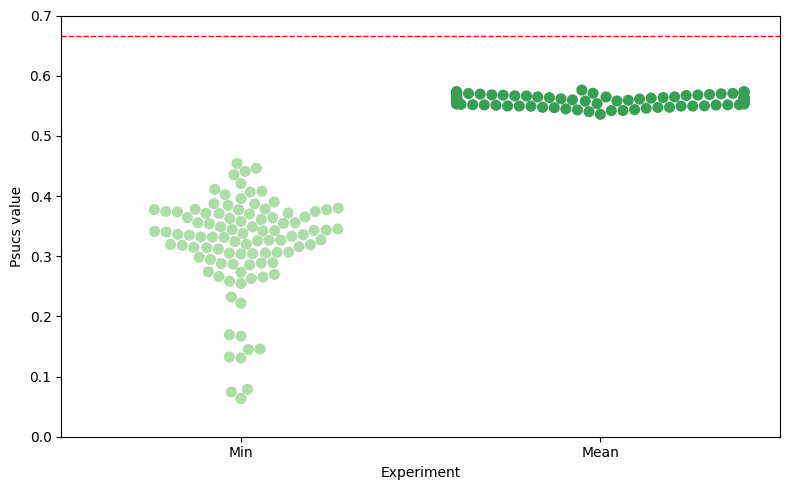

In [197]:
df = pd.DataFrame({
    "Psucs": np.concatenate([all_min_Psucs_1s_s1_setup5.flatten(), all_mean_Psucs_1s_s1_setup5.flatten()]),
    "Experiment": ["Min"] * len(all_min_Psucs_1s_s1_setup5.flatten()) + ["Mean"] * len(all_mean_Psucs_1s_s1_setup5.flatten())
})

plt.figure(figsize=(8, 5))
sns.swarmplot(
    x="Experiment", 
    y="Psucs", 
    hue="Experiment", 
    data=df, 
    palette="Greens", 
    size=8, 
    legend=False  # suppress the redundant legend
)

plt.axhline(y=2/3, color='r', linestyle='--', linewidth=1)
plt.ylim(0.0, 0.7)
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.tight_layout()
plt.show()


In [198]:
np.mean(all_mean_Psucs_1s_s1_setup5)

np.float64(0.5583596999999999)

In [199]:
last_thetas[0]

array([5.52550835, 3.20157239, 3.35023783, 1.8583923 , 3.57969789,
       3.40552939, 5.3872489 , 5.7724226 , 1.68273784, 5.57892999,
       4.0358913 , 4.12373052])

In [200]:
test_client = Client(None, None, None)
test_client.set_thetas(last_thetas[0])
# test_client.set_thetas(np.mean(last_thetas, axis=0))
compute_Psuccess(test_client)

0.5873063333333333

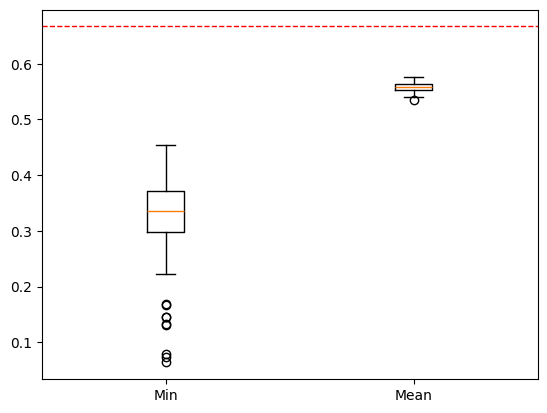

In [201]:
plt.boxplot([all_min_Psucs_1s_s1_setup5.flatten(), all_mean_Psucs_1s_s1_setup5.flatten()], tick_labels=["Min", "Mean"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

In [202]:
clients = create_clients_setup(
                num_clients=num_clients,
                num_samples=num_samples,
                sigma_range=sigma_range,
                seed=42,
                vqc_class=QuantumModel,
                n_shots=n_shots
            )

for client in clients:
    client._generate_labels()
    client.local_train(batch_size=len(client.labels), lr=opt_lr_1s_s1_setup5)

client = clients[0]
client.get_thetas()

array([5.81764428, 4.37387975, 3.59363756, 1.39770432, 1.13795155,
       0.36013075, 5.5215873 , 3.53604643, 4.57541661, 0.56319503,
       6.37713583, 5.0333437 ])


Test accuracy: 0.590
Confusion matrix (counts):
 [[341   1   0]
 [108  11 199]
 [100   2 238]]


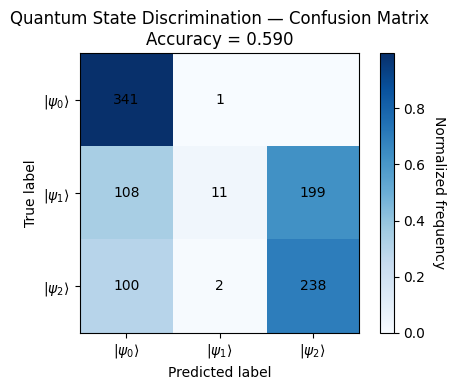

In [203]:
num_test_samples = 1000
test_labels = np.random.choice([0, 1, 2], size=num_test_samples, p=[1/3, 1/3, 1/3])

mapping = {"00":0, "01":1, "10":2}

true_labels = []
pred_labels = []

for idx, label in enumerate(test_labels[:]):
    x_input = label

    # Run model forward
    results = client.model(x_input, n_shots=1)
    probs = results.frequencies()
    # print(client.model(x_input, n_shots=None))
    # print("probs:", probs)
    # print("label:", label)

    # Convert bitstring frequencies into class probabilities
    pred = np.zeros(3)
    for bitstring, freq in probs.items():
        if bitstring in mapping:
            pred[mapping[bitstring]] += freq

    pred_label = pred.argmax()
    true_labels.append(label)
    pred_labels.append(pred_label)

# Compute confusion matrix manually
num_classes = 3
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    cm[t, p] += 1

# Normalize (optional, to show probabilities instead of counts)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"\nTest accuracy: {acc:.3f}")
print("Confusion matrix (counts):\n", cm)

# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_norm, cmap="Blues")

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i, j]}" if cm[i, j] > 0 else ""
        ax.text(j, i, text, ha="center", va="center", color="black")

# Axis labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_yticklabels([r"$|\psi_0⟩$", r"$|\psi_1⟩$", r"$|\psi_2⟩$"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Quantum State Discrimination — Confusion Matrix\nAccuracy = {acc:.3f}")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized frequency", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


#### Comparisons

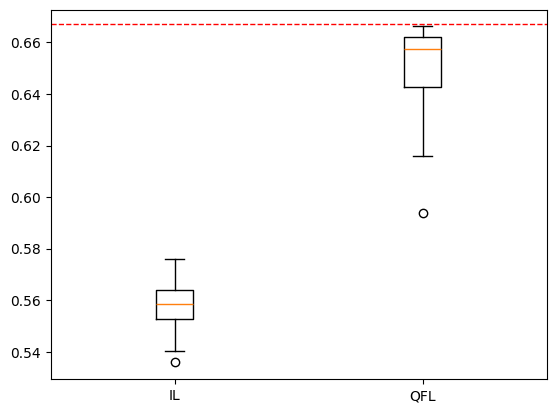

In [240]:
plt.boxplot([all_mean_Psucs_1s_s1_setup5.flatten(), QFL_Psucs_s1_setup5.flatten()], tick_labels=["IL", "QFL"])
plt.axhline(y=0.667, color='r', linestyle='--', linewidth=1)
plt.show()

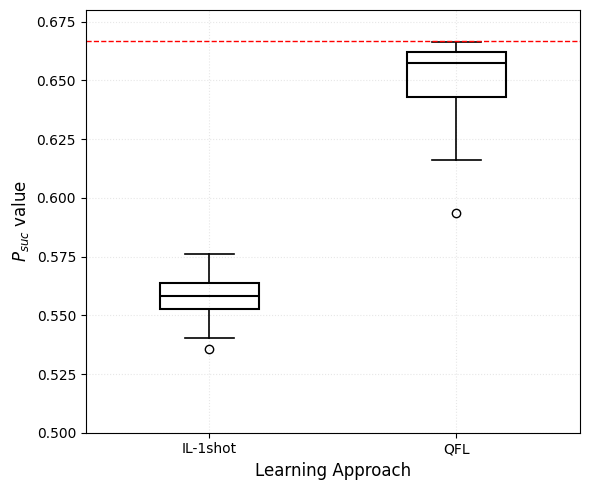

In [241]:
# Data
data = [all_mean_Psucs_1s_s1_setup5.flatten(), QFL_Psucs_s1_setup5.flatten()]
labels = ["IL-1shot", "QFL"]

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

plt.figure(figsize=(6, 5))

# Boxplot
bp = plt.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

# Apply colors to each box
# bp['boxes'][0].set_facecolor(color_SC)  # SC-1shot
# bp['boxes'][1].set_facecolor(color_QFL)  # QFL

# Reference line
plt.axhline(y=0.6667, color='r', linestyle='--', linewidth=1)

plt.ylabel("$P_{suc}$ value", fontsize=12)
plt.xlabel("Learning Approach", fontsize=12)
plt.ylim(0.50, 0.68)
plt.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.savefig("trine_setup1_sigma1.png", dpi=600, bbox_inches="tight")
plt.show()

In [242]:
print(np.mean(all_mean_Psucs_1s_s1_setup5))
print(np.mean(QFL_Psucs_s1_setup5))

0.5583596999999999
0.6513559999999999


In [243]:
print(np.min(all_mean_Psucs_1s_s1_setup5), np.max(all_mean_Psucs_1s_s1_setup5))
print(np.min(QFL_Psucs_s1_setup5), np.max(QFL_Psucs_s1_setup5))

0.535826 0.576014
0.5937 0.6662


# Cross-plots

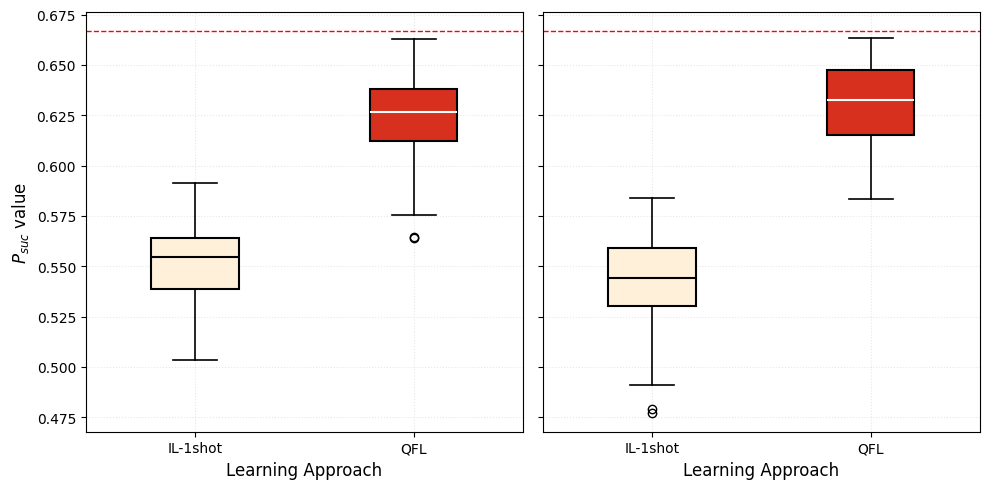

In [248]:
import matplotlib.pyplot as plt

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

labels = ["IL-1shot", "QFL"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# ---------- PLOT 1 ----------
data1 = [
    all_mean_Psucs_1s_s4_setup1.flatten(),
    QFL_Psucs_s4_setup1.flatten()
]

bp1 = axes[0].boxplot(
    data1,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

axes[0].axhline(y=0.6667, color='r', linestyle='--', linewidth=1)
axes[0].set_ylabel(r"$P_{suc}$ value", fontsize=12)
axes[0].set_xlabel("Learning Approach", fontsize=12)
axes[0].grid(True, linestyle=":", alpha=0.3)
#axes[0].set_title("Setup 1")

# ---------- PLOT 2 ----------
data2 = [
    all_mean_Psucs_1s_s4_setup2.flatten(),
    QFL_Psucs_s4_setup2.flatten()
]

bp2 = axes[1].boxplot(
    data2,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

axes[1].axhline(y=0.6667, color='r', linestyle='--', linewidth=1)
axes[1].set_xlabel("Learning Approach", fontsize=12)
axes[1].grid(True, linestyle=":", alpha=0.3)
#axes[1].set_title("Setup 2")

# Hide y-axis labels (numbers) on the right subplot, keep ticks
axes[1].tick_params(axis='y', labelleft=False)

# Color boxes
bp1['boxes'][0].set_facecolor("#fef0d9")   # IL-1shot
bp1['boxes'][1].set_facecolor("#d7301f")  # QFL
bp2['boxes'][0].set_facecolor("#fef0d9")   # IL-1shot
bp2['boxes'][1].set_facecolor("#d7301f")  # QFL

# Color medians
bp1['medians'][0].set_color("black")      # IL-1shot median
bp1['medians'][1].set_color("white")      # QFL median
bp2['medians'][0].set_color("black")      # IL-1shot median
bp2['medians'][1].set_color("white")      # QFL median



plt.tight_layout()
plt.savefig("trine_setups12_sigma4.png", dpi=600, bbox_inches="tight")
plt.show()

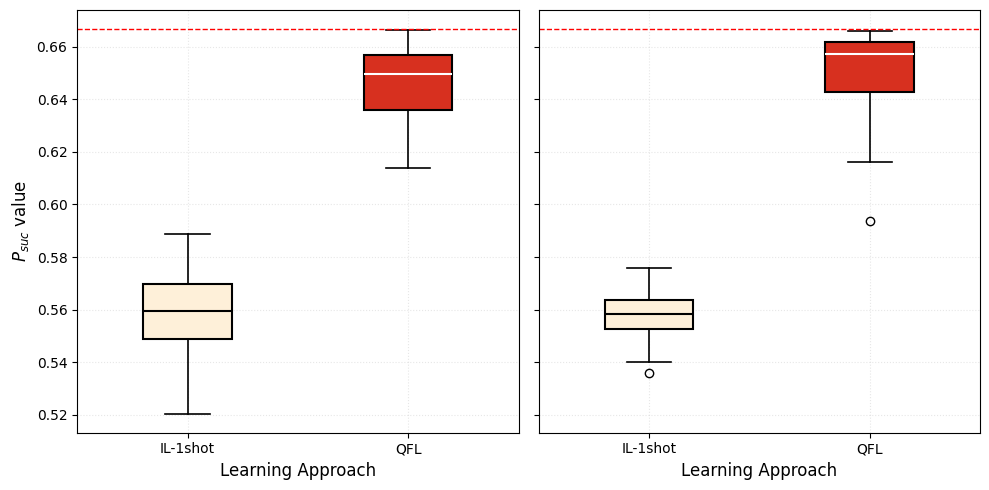

In [249]:
import matplotlib.pyplot as plt

# Colors
color_SC = "#fef0d9"
color_QFL = "#d7301f"
edge_color = "black"

labels = ["IL-1shot", "QFL"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# ---------- PLOT 1 ----------
data1 = [
    all_mean_Psucs_1s_s1_setup4.flatten(),
    QFL_Psucs_s1_setup4.flatten()
]

bp1 = axes[0].boxplot(
    data1,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

axes[0].axhline(y=0.6667, color='r', linestyle='--', linewidth=1)
axes[0].set_ylabel(r"$P_{suc}$ value", fontsize=12)
axes[0].set_xlabel("Learning Approach", fontsize=12)
axes[0].grid(True, linestyle=":", alpha=0.3)
#axes[0].set_title("Setup 1")

# ---------- PLOT 2 ----------
data2 = [
    all_mean_Psucs_1s_s1_setup5.flatten(),
    QFL_Psucs_s1_setup5.flatten()
]

bp2 = axes[1].boxplot(
    data2,
    tick_labels=labels,
    patch_artist=True,
    widths=0.4,
    medianprops=dict(color='black', linewidth=1.5),
    boxprops=dict(facecolor='none', edgecolor=edge_color, linewidth=1.5),
    whiskerprops=dict(color=edge_color, linewidth=1.2),
    capprops=dict(color=edge_color, linewidth=1.2),
    showfliers=True
)

axes[1].axhline(y=0.6667, color='r', linestyle='--', linewidth=1)
axes[1].set_xlabel("Learning Approach", fontsize=12)
axes[1].grid(True, linestyle=":", alpha=0.3)
#axes[1].set_title("Setup 2")

# Hide y-axis labels (numbers) on the right subplot, keep ticks
axes[1].tick_params(axis='y', labelleft=False)

# Color boxes
bp1['boxes'][0].set_facecolor("#fef0d9")   # IL-1shot
bp1['boxes'][1].set_facecolor("#d7301f")  # QFL
bp2['boxes'][0].set_facecolor("#fef0d9")   # IL-1shot
bp2['boxes'][1].set_facecolor("#d7301f")  # QFL

# Color medians
bp1['medians'][0].set_color("black")      # IL-1shot median
bp1['medians'][1].set_color("white")      # QFL median
bp2['medians'][0].set_color("black")      # IL-1shot median
bp2['medians'][1].set_color("white")      # QFL median



plt.tight_layout()
plt.savefig("trine_setups45_sigma1.png", dpi=600, bbox_inches="tight")
plt.show()